# **Análise de Dados - Shoply**

## 1. ENTENDIMENTO DOS DADOS

### 1.1 Configuração inicial

In [1]:
# Bibliotecas principais
import pandas as pd              # Manipulação de dados
import numpy as np               # Operações numéricas
import matplotlib.pyplot as plt  # Visualizações básicas
import seaborn as sns            # Visualizações estatísticas
from google.colab import drive   # Upload de arquivos do drive
from datetime import datetime
from datetime import timedelta
from pathlib import Path

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import lightgbm as lgb
import shap

In [2]:
# Configurações de display
pd.set_option("display.max_columns", None)   # Mostrar todas as colunas
pd.set_option("display.float_format", "{:,.2f}".format)  # Format numérico
sns.set(style="whitegrid", palette="viridis")  # Estilo padrão de gráficos

### 1.2 Carregamento dos dados

In [4]:
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Caminho da pasta onde os arquivos estão
DATA_PATH = "/content/drive/MyDrive/Shoply - Desafio de dados/"

In [6]:
# Carregar cada base separadamente
orders_raw = pd.read_csv(DATA_PATH + "orders_dirty_final.csv")

### 1.3 Exploração Inicial de Dados

In [7]:
# Avaliar tamanho das bases
orders_raw.shape

(501500, 13)

In [8]:
# Avaliar head da base
orders_raw.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,NaN,boleto,PR,2018-01-27,2018-01-26
1,2,2,2018-01-28,delivered,82.06,0.00,2,acessorios,NaN,credit_card,RJ,2018-01-30,2018-01-30
2,3,3,2018-01-17,delivered,501.8,18.16,1,eletro,NaN,boleto,CE,2018-01-27,2018-01-27
3,4,4,2018-01-02,delivered,85.76,-3.30,2,acessorios,NaN,credit_card,SP,2018-01-04,2018-01-04
4,5,5,2018-01-29,delivered,43.77,0.00,3,acessorios,NaN,credit_card,SP,2018-01-31,2018-01-31


In [9]:
orders_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501500 entries, 0 to 501499
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 501500 non-null  int64  
 1   customer_id              501500 non-null  int64  
 2   order_date               501500 non-null  object 
 3   order_status             501500 non-null  object 
 4   order_value              501500 non-null  object 
 5   discount_value           501498 non-null  float64
 6   sku_count                501303 non-null  object 
 7   order_category           501500 non-null  object 
 8   campaign_id              15408 non-null   object 
 9   payment_method           500492 non-null  object 
 10  delivery_state           501500 non-null  object 
 11  delivered_at             469122 non-null  object 
 12  estimated_delivery_date  501440 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 49.7+ MB


## 2. TRATAMENTO DOS DADOS

In [10]:
orders = orders_raw.copy()

#### Orders

Tipagem de dados

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501500 entries, 0 to 501499
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 501500 non-null  int64  
 1   customer_id              501500 non-null  int64  
 2   order_date               501500 non-null  object 
 3   order_status             501500 non-null  object 
 4   order_value              501500 non-null  object 
 5   discount_value           501498 non-null  float64
 6   sku_count                501303 non-null  object 
 7   order_category           501500 non-null  object 
 8   campaign_id              15408 non-null   object 
 9   payment_method           500492 non-null  object 
 10  delivery_state           501500 non-null  object 
 11  delivered_at             469122 non-null  object 
 12  estimated_delivery_date  501440 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 49.7+ MB


In [12]:
# Garantir que IDs sejam tratados como strings e não números
orders["order_id"] = orders["order_id"].astype(str)
orders["customer_id"] = orders["customer_id"].astype(str)

# Tipagens corretas
orders["order_date"] = pd.to_datetime(orders["order_date"], errors="coerce")
orders["order_value"]= pd.to_numeric(orders["order_value"], errors="coerce")
orders["discount_value"]= pd.to_numeric(orders["discount_value"], errors="coerce")
orders["sku_count"]  = pd.to_numeric(orders["sku_count"], errors="coerce")
orders["delivered_at"] = pd.to_datetime(orders["delivered_at"], errors="coerce")
orders["estimated_delivery_date"] = pd.to_datetime(orders["estimated_delivery_date"], errors="coerce")

Duplicatas

In [13]:
# Contar quantas duplicatas existem
dup_mask = orders["order_id"].duplicated(keep=False)
print("Qtd de linhas duplicadas em order_id:", dup_mask.sum())

Qtd de linhas duplicadas em order_id: 3000


In [14]:
# Ver primeira amostra das duplicatas
dup_sample = orders.loc[dup_mask].sort_values("order_id").head(6)
print("\nAmostra das duplicatas:\n", dup_sample)


Amostra das duplicatas:
        order_id customer_id order_date order_status  order_value  \
100082   100083        1840 2020-12-08    delivered        45.35   
501112   100083        1840 2020-12-08    delivered        45.35   
500676   100390       66254 2020-12-22    delivered       518.77   
100389   100390       66254 2020-12-22    delivered       518.77   
501306   100960       66571 2021-01-04    delivered        60.60   
100959   100960       66571 2021-01-04    delivered        60.60   

        discount_value  sku_count order_category campaign_id payment_method  \
100082            7.37       3.00     acessorios         NaN    credit_card   
501112            7.37       3.00     acessorios         NaN    credit_card   
500676          100.78       3.00           casa         NaN    credit_card   
100389          100.78       3.00           casa         NaN    credit_card   
501306            5.12       2.00     acessorios         NaN    credit_card   
100959            5.12 

In [15]:
# remove duplicata de ID mantendo a 1ª ocorrência
orders = orders[~orders["order_id"].duplicated(keep="first")].copy()

Arrumar valores numéricos

In [16]:
orders.describe()

,order_date,order_value,discount_value,sku_count,delivered_at,estimated_delivery_date
count,500000,"498,999.00","499,998.00","499,407.00",467209,499940
mean,2022-11-03 10:36:52.300799744,267.28,17.44,2.08,2022-11-02 01:56:20.844974848,2022-11-07 18:32:22.850742272
min,2018-01-01 00:00:00,-10.00,-268.88,-1.00,2018-01-01 00:00:00,2018-01-03 00:00:00
25%,2021-06-21 00:00:00,66.39,4.36,1.00,2021-06-14 00:00:00,2021-06-26 00:00:00
50%,2023-02-06 00:00:00,104.32,9.13,2.00,2023-02-04 00:00:00,2023-02-11 00:00:00
75%,2024-06-17 00:00:00,208.83,18.67,3.00,2024-06-18 00:00:00,2024-06-21 00:00:00
max,2026-04-26 00:00:00,"99,317.00","2,105.90",4.00,2025-12-31 00:00:00,2026-01-02 00:00:00
std,NaN,"2,171.34",30.56,0.86,NaN,NaN


In [17]:
# order_value
neg_mask = orders["order_value"] < 0
neg_rate = neg_mask.mean()
print(f"Taxa de order_value < 0: {neg_rate:.2%}")

Taxa de order_value < 0: 0.26%


In [18]:
# Se < 5%, remover
removed_neg = int(neg_mask.sum())
orders = orders[~neg_mask].copy()

In [19]:
# Definir ideal pra desconto
mask_neg   = orders["discount_value"] < 0

n_total = len(orders)
n_neg   = int(mask_neg.sum())
print(f"Registros totais: {n_total}")
print(f"Inválidos (<0): {n_neg} ({n_neg/n_total:.2%})")

Registros totais: 498723
Inválidos (<0): 478 (0.10%)


In [20]:
# Correção
orders.loc[orders["discount_value"] < 0, "discount_value"] = 0

In [21]:
# sku_count inválido → regra conservadora: mínimo 1, inteiro
# tudo que não for número vira NaN já na tipagem; agora imputamos 1
orders.loc[orders["sku_count"].isna() | (orders["sku_count"] < 1), "sku_count"] = 1

# força inteiro
orders["sku_count"] = orders["sku_count"].round().astype(int)

Lógica delivery

In [22]:
# delivered_at antes da compra
mask_before_order = orders["delivered_at"].notna() & (orders["delivered_at"] < orders["order_date"])
# delivered_at preenchido quando não deveria
mask_shouldnt_have = orders["delivered_at"].notna() & orders["order_status"].isin(["cancelled","refunded","processing"])
# delivered_at vazio quando devia tá preenchido
mask_missing_but_should = orders["delivered_at"].isna() & orders["order_status"].isin(["delivered","returned"])
# estimated_delivery antes da compra
mask_bad_est = (orders["estimated_delivery_date"].notna() & (orders["estimated_delivery_date"] < orders["order_date"]))

print("Resumo inicial de erros detectados:\n")
print("Delivered_at antes da compra:", mask_before_order.sum())
print("Delivered_at preenchido quando não deveria:", mask_shouldnt_have.sum())
print("Delivered_at vazio quando devia tá preenchido:", mask_missing_but_should.sum())
print("Estimated_delivery antes da compra:", mask_bad_est.sum())

Resumo inicial de erros detectados:

Delivered_at antes da compra: 2629
Delivered_at preenchido quando não deveria: 985
Delivered_at vazio quando devia tá preenchido: 936
Estimated_delivery antes da compra: 2232


In [23]:
# 1) delivered_at antes de order_date → limpar
orders.loc[mask_before_order, "delivered_at"] = pd.NaT

In [24]:
# 2) delivered_at presente em status sem entrega → limpar
orders.loc[mask_shouldnt_have, "delivered_at"] = pd.NaT

In [25]:
# 3) Arrumar tempo estimado
# SLA simples por estado
sla_map = {
    "AC": 8,"AL": 8,"AM": 8,"AP": 8,"BA": 8,"CE": 8,"PA": 8,"PB": 8,"PE": 8,"PI": 8,"MA": 8,"RN": 8,"RO": 8,"RR": 8,"SE": 8,"TO": 8,
    "DF": 5,"GO": 5,"MT": 5,"MS": 5,"PR": 5,"SC": 5,"RS": 5,
    "SP": 3,"RJ": 3,"MG": 3,"ES": 3
}

orders["sla_days"] = orders["delivery_state"].map(sla_map).fillna(5)

orders.loc[mask_bad_est, "estimated_delivery_date"] = (
    orders.loc[mask_bad_est, "order_date"] +
    pd.to_timedelta(orders.loc[mask_bad_est, "sla_days"], unit="D")
)

In [26]:
# 4) delivered_at ausente mas deveria ter → imputar
#     regra: usar estimated_delivery_date; se NaT, usar order_date

mask_missing_but_should = orders["delivered_at"].isna() & orders["order_status"].isin(["delivered","returned"])
fill_est = orders.loc[mask_missing_but_should, "estimated_delivery_date"]
fill_ord = orders.loc[mask_missing_but_should, "order_date"]

orders.loc[mask_missing_but_should, "delivered_at"] = fill_est.fillna(fill_ord)

Normalização de campos categóricos

In [27]:
orders["payment_method"].unique()

array(['boleto', 'credit_card', 'paypal', '-', ' credit_card ', 'pixx',
       'credit_card  ', ' CREDIT_CARD  ', nan, ' CREDIT_CARD ',
       'paypal   ', ' credit_card', ' credit_card  ', 'CREDIT_CARD ',
       ' boleto  ', 'boleto_bancario', 'CREDITCARD', 'credit_card ',
       '(blank)', ' CREDIT_CARD', 'CREDIT_CARD', ' paypal ', ' BOLETO  ',
       'CREDIT_CARD  ', 'boleto ', 'BOLETO  ', ' boleto ', 'boleto  ',
       'BOLETO ', 'paypal  ', ' BOLETO', ' PAYPAL ', 'BOLETO', ' boleto',
       ' paypal', 'PAYPAL  ', 'pix', ' pix ', ' pix  ', 'PIX', 'pix  ',
       'PIX  ', ' pix', ' PAYPAL  ', 'PIX ', ' PIX', 'pix ', ' PIX  ',
       ' PIX ', ' BOLETO ', 'paypal ', 'PAYPAL', ' PIXX  ',
       ' PAYPAL     ', ' paypal  ', ' ', ' PAYPAL', 'creditcard  ',
       'NULL  ', 'PAYPAL '], dtype=object)

In [28]:
# Normalização discreta de campos categóricos para reduzir ruído inadvertido
if "payment_method" in orders.columns:
    orders["payment_method"] = orders["payment_method"].str.lower().str.strip()
if "delivery_state" in orders.columns:
    orders["delivery_state"] = orders["delivery_state"].str.upper().str.strip()
if "order_status" in orders.columns:
    orders["order_status"] = orders["order_status"].str.lower().str.strip()
if "order_category" in orders.columns:
    orders["order_category"] = orders["order_category"].str.lower().str.strip()

Nulos

In [29]:
# Nulos críticos
crit_cols_orders = ["order_id","customer_id","order_date","order_value"]
print(orders[crit_cols_orders].isna().sum())

order_id          0
customer_id       0
order_date        0
order_value    1001
dtype: int64


In [30]:
# Aplicar dropna
orders = orders.dropna(subset=["order_value"]).copy()

Arrumar payment methods

In [31]:
orders['payment_method'].unique()

array(['boleto', 'credit_card', 'paypal', '-', 'pixx', nan,
       'boleto_bancario', 'creditcard', '(blank)', 'pix', '', 'null'],
      dtype=object)

In [32]:
orders["payment_method"] = (
    orders["payment_method"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"": None, "nan": None, "null": None, "-": None, "(blank)": None})
    .replace({
        "creditcard": "credit_card",
        "credit_card": "credit_card",
        "pixx": "pix",
        "pix": "pix",
        "boleto_bancario": "boleto",
        "boleto": "boleto",
        "paypal": "paypal",
    })
)


Arrumar state

In [33]:
orders['delivery_state'].unique()

array(['PR', 'RJ', 'CE', 'SP', 'MG', 'AC', 'SC', 'RS', 'BA', 'PE', 'MA',
       'PB', 'MT', 'ES', 'RN', '??', 'PA', 'GO', 'RO', 'RR', 'TO', 'DF',
       'SE', 'AM', 'MS', 'AL', 'PI', 'AP', 'XX', 'BR'], dtype=object)

In [34]:
orders["delivery_state"] = (
    orders["delivery_state"]
    .astype(str)
    .str.strip()
    .replace({
        "??": "XX"
    })
)

Arrumar datas erradas

In [35]:
orders[orders["order_date"] > "2025-11-30"]

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days
3080,3081,2570,2026-01-02,delivered,46.75,1.58,2,acessorios,NaN,credit_card,RJ,2026-01-05,2026-01-05,3.00
3202,3203,2663,2026-01-01,delivered,144.29,10.20,2,acessorios,NaN,credit_card,PR,2026-01-06,2026-01-06,5.00
3759,3760,3052,2026-01-02,delivered,200.06,11.88,1,acessorios,NaN,credit_card,PA,2026-01-10,2026-01-10,8.00
3896,3897,776,2026-01-03,delivered,87.82,0.00,3,acessorios,NaN,credit_card,PR,2026-01-08,2026-01-08,5.00
9169,9170,5501,2026-01-01,delivered,92.59,0.85,3,acessorios,NaN,credit_card,MG,2026-01-04,2026-01-04,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497878,497879,107757,2025-12-22,delivered,45.87,13.54,3,acessorios,NaN,pix,BA,2025-12-30,2025-12-30,8.00
497935,497936,277835,2026-03-31,delivered,173.53,32.43,3,casa,NaN,credit_card,RJ,2026-04-03,2026-04-03,3.00
498621,498622,242735,2026-03-14,delivered,464.16,77.79,2,eletro,NaN,pix,MG,2026-03-17,2026-03-17,3.00
498704,498705,278276,2026-01-01,delivered,58.18,18.26,3,beleza,NaN,boleto,AL,2026-01-09,2026-01-09,8.00


In [36]:
orders = orders[orders["order_date"] <= "2025-11-30"]

Arrumar campanhas

In [37]:
orders['campaign_id'].nunique()

1079

In [38]:
orders["campaign_id"] = (
    orders["campaign_id"]
    .astype(str)
    .str.strip()
    .replace({"": None, "nan": None, "null": None, "-": None, "(blank)": None, "N/A": None})
)

## 3. CRIAÇÃO DE FEATURES

In [39]:
orders.to_excel("orders_clean.xlsx")

### Features de pedido

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00
1,2,2,2018-01-28,delivered,82.06,0.00,2,acessorios,None,credit_card,RJ,2018-01-30,2018-01-30,3.00
2,3,3,2018-01-17,delivered,501.80,18.16,1,eletro,None,boleto,CE,2018-01-27,2018-01-27,8.00
3,4,4,2018-01-02,delivered,85.76,0.00,2,acessorios,None,credit_card,SP,2018-01-04,2018-01-04,3.00
4,5,5,2018-01-29,delivered,43.77,0.00,3,acessorios,None,credit_card,SP,2018-01-31,2018-01-31,3.00


In [ ]:
# primeira compra do cliente
orders["is_new_customer"] = (
    orders.groupby("customer_id")["order_date"].transform("min") == orders["order_date"]
).astype(int)

In [ ]:
# Valor bruto e métricas de entrega
orders["total_order_value"] = orders["order_value"] + orders["discount_value"]
orders["pct_discount"] = orders["discount_value"]/orders["total_order_value"]
orders["days_to_delivery"] = (orders["delivered_at"] - orders["order_date"]).dt.days
orders["delivery_delay_days"] = (orders["delivered_at"] - orders["estimated_delivery_date"]).dt.days
orders["is_late_delivery"] = (orders["delivery_delay_days"] > 0).astype("Int8")

In [ ]:
# Particionamento temporal
orders["order_year"]  = orders["order_date"].dt.year
orders["order_month"] = orders["order_date"].dt.month
orders["order_month_year"] = orders["order_date"].dt.to_period("M")
orders["order_week"]  = orders["order_date"].dt.isocalendar().week.astype("Int64")

In [ ]:
# Sazonalidade
orders["holiday_tag"] = ""
orders.loc[orders["order_date"].dt.month == 11, "holiday_tag"] = "black_friday"
orders.loc[orders["order_date"].dt.month == 12, "holiday_tag"] = "christmas"
orders.loc[orders["order_date"].dt.month == 5,  "holiday_tag"] = "mothers_day"
orders["holiday_tag"] = orders["holiday_tag"].replace("", "normal")

In [ ]:
# Calcular quartis do ticket líquido
q1, q2, q3 = orders["order_value"].quantile([0.25, 0.50, 0.75])

print(f"Quartis do net_order_value:\nQ1={q1:.2f} | Q2={q2:.2f} | Q3={q3:.2f}")

Quartis do net_order_value:
Q1=66.64 | Q2=104.56 | Q3=209.37


In [ ]:
# Classificar ticket em 4 faixas
orders["basket_size_flag"] = pd.cut(
    orders["order_value"],
    bins=[-1, q1, q2, q3, orders["order_value"].max()],
    labels=["Q1_low","Q2_mid_low","Q3_mid_high","Q4_high"]
)

# High-ticket definido como Q4
orders["high_ticket_flag"] = (orders["order_value"] >= q3).astype("Int8")

In [ ]:
# Histórico incremental por cliente
orders = orders.sort_values(["customer_id","order_date","order_id"])
orders["customer_lifetime_orders"] = orders.groupby("customer_id").cumcount() + 1 # Número acumulado de pedidos por cliente (1ª, 2ª, 3ª compra etc.)
orders["customer_lifetime_gmv"] = orders.groupby("customer_id")["order_value"].cumsum() # GMV acumulado até o pedido atual

In [ ]:
# Ticket médio até o pedido atual
orders["customer_avg_ticket_to_date"] = (
    orders["customer_lifetime_gmv"] / orders["customer_lifetime_orders"]
)

In [ ]:
# Dias desde a última compra antes da compra atual
orders["prev_order_date"] = orders.groupby("customer_id")["order_date"].shift(1) # Data do pedido anterior do mesmo cliente
orders["days_since_last_order_before_purchase"] = (
    orders["order_date"] - orders["prev_order_date"]
).dt.days

In [ ]:
# Region (via UF) — nível pedido
uf_to_region = {
    "SP":"Sudeste","RJ":"Sudeste","MG":"Sudeste","ES":"Sudeste",
    "PR":"Sul","SC":"Sul","RS":"Sul",
    "DF":"Centro-Oeste","GO":"Centro-Oeste","MT":"Centro-Oeste","MS":"Centro-Oeste",
    "BA":"Nordeste","PE":"Nordeste","CE":"Nordeste","RN":"Nordeste","PB":"Nordeste","MA":"Nordeste","AL":"Nordeste","SE":"Nordeste","PI":"Nordeste",
    "PA":"Norte","AM":"Norte","RO":"Norte","RR":"Norte","AC":"Norte","AP":"Norte","TO":"Norte"
}
orders["region"] = orders["delivery_state"].map(uf_to_region).fillna("Desconhecida")


In [ ]:
# Identificar "novos" vs "recorrentes"

# Um cliente é "novo" se essa order é a primeira dele na série
orders = orders.sort_values(["customer_id", "order_date"])
orders["is_new_customer_period"] = orders["prev_order_date"].isna()


In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
orders.to_excel("orders_features.xlsx")

### Features de diagnóstico

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
# Base de métricas gerais por mês pra facilitar diagnóstico

monthly = (
    orders.groupby("order_month_year")
    .agg(
        total_gmv=("order_value", "sum"),
        total_orders=("order_id", "nunique"),
        active_customers=("customer_id", "nunique"),
    )
)

monthly["aov"] = monthly["total_gmv"] / monthly["total_orders"]
monthly["orders_per_customer"] = monthly["total_orders"] / monthly["active_customers"]

In [ ]:
# Base auxiliar de infos pdiferenciando novos clientes de antigos
seg = (
    orders.groupby(["order_month_year", "is_new_customer_period"])
    .agg(
        gmv=("order_value", "sum"),
        orders=("order_id", "nunique"),
        customers=("customer_id", "nunique"),
    )
    .reset_index()
)

# Pivot para ficar legível
seg = seg.pivot(
    index="order_month_year",
    columns="is_new_customer_period",
    values=["gmv", "orders", "customers"]
)

seg.columns = [
    f"{metric}_{'new' if flag else 'returning'}"
    for metric, flag in seg.columns]

In [ ]:
seg.head()

,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new
order_month_year,,,,,,
2018-01,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00"
2018-02,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00"
2018-03,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00"
2018-04,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00"
2018-05,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00"


In [ ]:
# Unir tudo

# garantir formatos iguais para o join
monthly.index = monthly.index.astype(str)
seg.index = seg.index.astype(str)

diagnostic = monthly.join(seg, how="left")

In [ ]:
diagnostic.head()

,total_gmv,total_orders,active_customers,aov,orders_per_customer,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new
order_month_year,,,,,,,,,,,
2018-01,"330,690.26",1391,1391,237.74,1.00,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00"
2018-02,"299,961.84",1591,1496,188.54,1.06,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00"
2018-03,"313,461.72",1722,1662,182.03,1.04,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00"
2018-04,"305,153.42",1804,1756,169.15,1.03,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00"
2018-05,"452,670.43",1903,1875,237.87,1.01,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00"


In [ ]:
# Métricas derivadas

diagnostic["gmv_share_new"] = diagnostic["gmv_new"] / diagnostic["total_gmv"]

diagnostic["share_new"] = diagnostic["orders_new"] / diagnostic["total_orders"]

diagnostic["aov_new"] = diagnostic["gmv_new"] / diagnostic["orders_new"]
diagnostic["aov_returning"] = diagnostic["gmv_returning"] / diagnostic["orders_returning"] #Average Order Value.

diagnostic["orders_per_customer_new"] = (
    diagnostic["orders_new"] / diagnostic["customers_new"]
)
diagnostic["orders_per_customer_returning"] = (
    diagnostic["orders_returning"] / diagnostic["customers_returning"]
)

diagnostic.head(6)

,total_gmv,total_orders,active_customers,aov,orders_per_customer,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new,gmv_share_new,share_new,aov_new,aov_returning,orders_per_customer_new,orders_per_customer_returning
order_month_year,,,,,,,,,,,,,,,,,
2018-01,"330,690.26",1391,1391,237.74,1.00,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00",1.00,1.00,237.74,NaN,1.00,NaN
2018-02,"299,961.84",1591,1496,188.54,1.06,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00",0.79,0.70,213.35,130.23,1.00,1.25
2018-03,"313,461.72",1722,1662,182.03,1.04,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00",0.79,0.70,203.77,130.53,1.00,1.13
2018-04,"305,153.42",1804,1756,169.15,1.03,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00",0.76,0.70,183.63,135.54,1.00,1.10
2018-05,"452,670.43",1903,1875,237.87,1.01,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00",0.73,0.70,246.28,218.11,1.00,1.05
2018-06,"350,946.26",1868,1844,187.87,1.01,"110,661.96","240,284.30",558.00,"1,310.00",534.00,"1,310.00",0.68,0.70,183.42,198.32,1.00,1.04


In [ ]:
diagnostic.columns

Index(['total_gmv', 'total_orders', 'active_customers', 'aov',
       'orders_per_customer', 'gmv_returning', 'gmv_new', 'orders_returning',
       'orders_new', 'customers_returning', 'customers_new', 'gmv_share_new',
       'share_new', 'aov_new', 'aov_returning', 'orders_per_customer_new',
       'orders_per_customer_returning'],
      dtype='object')

### Features de clientes

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_date', 'order_status', 'order_value',
       'discount_value', 'sku_count', 'order_category', 'campaign_id',
       'payment_method', 'delivery_state', 'delivered_at',
       'estimated_delivery_date', 'sla_days', 'is_new_customer',
       'total_order_value', 'pct_discount', 'days_to_delivery',
       'delivery_delay_days', 'is_late_delivery', 'order_year', 'order_month',
       'order_month_year', 'order_week', 'holiday_tag', 'basket_size_flag',
       'high_ticket_flag', 'customer_lifetime_orders', 'customer_lifetime_gmv',
       'customer_avg_ticket_to_date', 'prev_order_date',
       'days_since_last_order_before_purchase', 'region',
       'is_new_customer_period'],
      dtype='object')

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
# Construção da base customers a partir de orders
customers = (
    orders[["customer_id"]]
    .dropna()
    .drop_duplicates()
    .sort_values("customer_id")
    .reset_index(drop=True)
)

In [ ]:
customers.head()

,customer_id
0,1
1,10
2,100
3,1000
4,10000


In [ ]:
# Período de relacionamento

tmp = (
    orders.groupby("customer_id")["order_date"]
    .agg(first_order_date="min", last_order_date="max")
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

today = pd.Timestamp.today().normalize()  # data de hoje sem horário

customers["total_days_as_customer"] = (today - customers["first_order_date"]).dt.days

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_date', 'order_status', 'order_value',
       'discount_value', 'sku_count', 'order_category', 'campaign_id',
       'payment_method', 'delivery_state', 'delivered_at',
       'estimated_delivery_date', 'sla_days', 'is_new_customer',
       'total_order_value', 'pct_discount', 'days_to_delivery',
       'delivery_delay_days', 'is_late_delivery', 'order_year', 'order_month',
       'order_month_year', 'order_week', 'holiday_tag', 'basket_size_flag',
       'high_ticket_flag', 'customer_lifetime_orders', 'customer_lifetime_gmv',
       'customer_avg_ticket_to_date', 'prev_order_date',
       'days_since_last_order_before_purchase', 'region',
       'is_new_customer_period'],
      dtype='object')

In [ ]:
# Volume e valor

tmp = (
    orders.groupby("customer_id")
    .agg(
        total_orders=("order_id","count"),
        total_gmv=("order_value","sum"),
        avg_order_value=("order_value","mean"),
        median_order_value=("order_value","median"),
        total_discount=("discount_value","sum"),
        avg_pct_discount=("pct_discount","mean"),
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Mix e perfil de compra

tmp = (
    orders.groupby("customer_id")
    .agg(
        unique_categories=("order_category","nunique"),
        avg_sku_per_order=("sku_count","mean"),
        pct_high_ticket=("high_ticket_flag","mean"),  # proporção Q4
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Logística e experiência

tmp = (
    orders.groupby("customer_id")
    .agg(
        avg_days_to_delivery=("days_to_delivery","mean"),
        pct_deliveries_late=("is_late_delivery","mean"),
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Região mais frequente

tmp = (
    orders.groupby("customer_id")["region"]
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
    .reset_index(name="most_frequent_region")
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Recompra e relacionamento

tmp = (
    orders.groupby("customer_id")["days_since_last_order_before_purchase"]
    .agg(avg_days_between_orders="mean", max_days_between_orders="max")
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Método de pagamento mais usado

tmp = (
    orders.groupby("customer_id")["payment_method"]
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
    .reset_index(name="most_used_payment")
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Mais algumas temporais

latest_date = orders["order_date"].max()
customers["days_since_last_order"] = (today - customers["last_order_date"]).dt.days
customers["is_active_90d"] = (customers["days_since_last_order"] <= 90).astype("Int8")

In [ ]:
# Coorte de entrada
customers["first_order_date"] = pd.to_datetime(customers["first_order_date"], errors="coerce")
customers["cohort_month"] = customers["first_order_date"].dt.to_period("M").astype(str)

In [ ]:
customers.columns

Index(['customer_id', 'first_order_date', 'last_order_date',
       'total_days_as_customer', 'total_orders', 'total_gmv',
       'avg_order_value', 'median_order_value', 'total_discount',
       'avg_pct_discount', 'unique_categories', 'avg_sku_per_order',
       'pct_high_ticket', 'avg_days_to_delivery', 'pct_deliveries_late',
       'most_frequent_region', 'avg_days_between_orders',
       'max_days_between_orders', 'most_used_payment', 'days_since_last_order',
       'is_active_90d', 'cohort_month'],
      dtype='object')

In [ ]:
customers.to_excel("customers_features.xlsx")

## 3. CRIAÇÃO DE FEATURES

In [ ]:
orders.to_excel("orders_clean.xlsx")

### Features de pedido

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00
1,2,2,2018-01-28,delivered,82.06,0.00,2,acessorios,None,credit_card,RJ,2018-01-30,2018-01-30,3.00
2,3,3,2018-01-17,delivered,501.80,18.16,1,eletro,None,boleto,CE,2018-01-27,2018-01-27,8.00
3,4,4,2018-01-02,delivered,85.76,0.00,2,acessorios,None,credit_card,SP,2018-01-04,2018-01-04,3.00
4,5,5,2018-01-29,delivered,43.77,0.00,3,acessorios,None,credit_card,SP,2018-01-31,2018-01-31,3.00


In [ ]:
# primeira compra do cliente
orders["is_new_customer"] = (
    orders.groupby("customer_id")["order_date"].transform("min") == orders["order_date"]
).astype(int)

In [ ]:
# Valor bruto e métricas de entrega
orders["total_order_value"] = orders["order_value"] + orders["discount_value"]
orders["pct_discount"] = orders["discount_value"]/orders["total_order_value"]
orders["days_to_delivery"] = (orders["delivered_at"] - orders["order_date"]).dt.days
orders["delivery_delay_days"] = (orders["delivered_at"] - orders["estimated_delivery_date"]).dt.days
orders["is_late_delivery"] = (orders["delivery_delay_days"] > 0).astype("Int8")

In [ ]:
# Particionamento temporal
orders["order_year"]  = orders["order_date"].dt.year
orders["order_month"] = orders["order_date"].dt.month
orders["order_month_year"] = orders["order_date"].dt.to_period("M")
orders["order_week"]  = orders["order_date"].dt.isocalendar().week.astype("Int64")

In [ ]:
# Sazonalidade
orders["holiday_tag"] = ""
orders.loc[orders["order_date"].dt.month == 11, "holiday_tag"] = "black_friday"
orders.loc[orders["order_date"].dt.month == 12, "holiday_tag"] = "christmas"
orders.loc[orders["order_date"].dt.month == 5,  "holiday_tag"] = "mothers_day"
orders["holiday_tag"] = orders["holiday_tag"].replace("", "normal")

In [ ]:
# Calcular quartis do ticket líquido
q1, q2, q3 = orders["order_value"].quantile([0.25, 0.50, 0.75])

print(f"Quartis do net_order_value:\nQ1={q1:.2f} | Q2={q2:.2f} | Q3={q3:.2f}")

Quartis do net_order_value:
Q1=66.64 | Q2=104.56 | Q3=209.37


In [ ]:
# Classificar ticket em 4 faixas
orders["basket_size_flag"] = pd.cut(
    orders["order_value"],
    bins=[-1, q1, q2, q3, orders["order_value"].max()],
    labels=["Q1_low","Q2_mid_low","Q3_mid_high","Q4_high"]
)

# High-ticket definido como Q4
orders["high_ticket_flag"] = (orders["order_value"] >= q3).astype("Int8")

In [ ]:
# Histórico incremental por cliente
orders = orders.sort_values(["customer_id","order_date","order_id"])
orders["customer_lifetime_orders"] = orders.groupby("customer_id").cumcount() + 1 # Número acumulado de pedidos por cliente (1ª, 2ª, 3ª compra etc.)
orders["customer_lifetime_gmv"] = orders.groupby("customer_id")["order_value"].cumsum() # GMV acumulado até o pedido atual

In [ ]:
# Ticket médio até o pedido atual
orders["customer_avg_ticket_to_date"] = (
    orders["customer_lifetime_gmv"] / orders["customer_lifetime_orders"]
)

In [ ]:
# Dias desde a última compra antes da compra atual
orders["prev_order_date"] = orders.groupby("customer_id")["order_date"].shift(1) # Data do pedido anterior do mesmo cliente
orders["days_since_last_order_before_purchase"] = (
    orders["order_date"] - orders["prev_order_date"]
).dt.days

In [ ]:
# Region (via UF) — nível pedido
uf_to_region = {
    "SP":"Sudeste","RJ":"Sudeste","MG":"Sudeste","ES":"Sudeste",
    "PR":"Sul","SC":"Sul","RS":"Sul",
    "DF":"Centro-Oeste","GO":"Centro-Oeste","MT":"Centro-Oeste","MS":"Centro-Oeste",
    "BA":"Nordeste","PE":"Nordeste","CE":"Nordeste","RN":"Nordeste","PB":"Nordeste","MA":"Nordeste","AL":"Nordeste","SE":"Nordeste","PI":"Nordeste",
    "PA":"Norte","AM":"Norte","RO":"Norte","RR":"Norte","AC":"Norte","AP":"Norte","TO":"Norte"
}
orders["region"] = orders["delivery_state"].map(uf_to_region).fillna("Desconhecida")


In [ ]:
# Identificar "novos" vs "recorrentes"

# Um cliente é "novo" se essa order é a primeira dele na série
orders = orders.sort_values(["customer_id", "order_date"])
orders["is_new_customer_period"] = orders["prev_order_date"].isna()


In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
orders.to_excel("orders_features.xlsx")

### Features de diagnóstico

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
# Base de métricas gerais por mês pra facilitar diagnóstico

monthly = (
    orders.groupby("order_month_year")
    .agg(
        total_gmv=("order_value", "sum"),
        total_orders=("order_id", "nunique"),
        active_customers=("customer_id", "nunique"),
    )
)

monthly["aov"] = monthly["total_gmv"] / monthly["total_orders"]
monthly["orders_per_customer"] = monthly["total_orders"] / monthly["active_customers"]

In [ ]:
# Base auxiliar de infos pdiferenciando novos clientes de antigos
seg = (
    orders.groupby(["order_month_year", "is_new_customer_period"])
    .agg(
        gmv=("order_value", "sum"),
        orders=("order_id", "nunique"),
        customers=("customer_id", "nunique"),
    )
    .reset_index()
)

# Pivot para ficar legível
seg = seg.pivot(
    index="order_month_year",
    columns="is_new_customer_period",
    values=["gmv", "orders", "customers"]
)

seg.columns = [
    f"{metric}_{'new' if flag else 'returning'}"
    for metric, flag in seg.columns]

In [ ]:
seg.head()

,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new
order_month_year,,,,,,
2018-01,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00"
2018-02,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00"
2018-03,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00"
2018-04,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00"
2018-05,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00"


In [ ]:
# Unir tudo

# garantir formatos iguais para o join
monthly.index = monthly.index.astype(str)
seg.index = seg.index.astype(str)

diagnostic = monthly.join(seg, how="left")

In [ ]:
diagnostic.head()

,total_gmv,total_orders,active_customers,aov,orders_per_customer,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new
order_month_year,,,,,,,,,,,
2018-01,"330,690.26",1391,1391,237.74,1.00,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00"
2018-02,"299,961.84",1591,1496,188.54,1.06,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00"
2018-03,"313,461.72",1722,1662,182.03,1.04,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00"
2018-04,"305,153.42",1804,1756,169.15,1.03,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00"
2018-05,"452,670.43",1903,1875,237.87,1.01,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00"


In [ ]:
# Métricas derivadas

diagnostic["gmv_share_new"] = diagnostic["gmv_new"] / diagnostic["total_gmv"]

diagnostic["share_new"] = diagnostic["orders_new"] / diagnostic["total_orders"]

diagnostic["aov_new"] = diagnostic["gmv_new"] / diagnostic["orders_new"]
diagnostic["aov_returning"] = diagnostic["gmv_returning"] / diagnostic["orders_returning"] #Average Order Value.

diagnostic["orders_per_customer_new"] = (
    diagnostic["orders_new"] / diagnostic["customers_new"]
)
diagnostic["orders_per_customer_returning"] = (
    diagnostic["orders_returning"] / diagnostic["customers_returning"]
)

diagnostic.head(6)

,total_gmv,total_orders,active_customers,aov,orders_per_customer,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new,gmv_share_new,share_new,aov_new,aov_returning,orders_per_customer_new,orders_per_customer_returning
order_month_year,,,,,,,,,,,,,,,,,
2018-01,"330,690.26",1391,1391,237.74,1.00,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00",1.00,1.00,237.74,NaN,1.00,NaN
2018-02,"299,961.84",1591,1496,188.54,1.06,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00",0.79,0.70,213.35,130.23,1.00,1.25
2018-03,"313,461.72",1722,1662,182.03,1.04,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00",0.79,0.70,203.77,130.53,1.00,1.13
2018-04,"305,153.42",1804,1756,169.15,1.03,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00",0.76,0.70,183.63,135.54,1.00,1.10
2018-05,"452,670.43",1903,1875,237.87,1.01,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00",0.73,0.70,246.28,218.11,1.00,1.05
2018-06,"350,946.26",1868,1844,187.87,1.01,"110,661.96","240,284.30",558.00,"1,310.00",534.00,"1,310.00",0.68,0.70,183.42,198.32,1.00,1.04


In [ ]:
diagnostic.columns

Index(['total_gmv', 'total_orders', 'active_customers', 'aov',
       'orders_per_customer', 'gmv_returning', 'gmv_new', 'orders_returning',
       'orders_new', 'customers_returning', 'customers_new', 'gmv_share_new',
       'share_new', 'aov_new', 'aov_returning', 'orders_per_customer_new',
       'orders_per_customer_returning'],
      dtype='object')

### Features de clientes

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_date', 'order_status', 'order_value',
       'discount_value', 'sku_count', 'order_category', 'campaign_id',
       'payment_method', 'delivery_state', 'delivered_at',
       'estimated_delivery_date', 'sla_days', 'is_new_customer',
       'total_order_value', 'pct_discount', 'days_to_delivery',
       'delivery_delay_days', 'is_late_delivery', 'order_year', 'order_month',
       'order_month_year', 'order_week', 'holiday_tag', 'basket_size_flag',
       'high_ticket_flag', 'customer_lifetime_orders', 'customer_lifetime_gmv',
       'customer_avg_ticket_to_date', 'prev_order_date',
       'days_since_last_order_before_purchase', 'region',
       'is_new_customer_period'],
      dtype='object')

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
# Construção da base customers a partir de orders
customers = (
    orders[["customer_id"]]
    .dropna()
    .drop_duplicates()
    .sort_values("customer_id")
    .reset_index(drop=True)
)

In [ ]:
customers.head()

,customer_id
0,1
1,10
2,100
3,1000
4,10000


In [ ]:
# Período de relacionamento

tmp = (
    orders.groupby("customer_id")["order_date"]
    .agg(first_order_date="min", last_order_date="max")
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

today = pd.Timestamp.today().normalize()  # data de hoje sem horário

customers["total_days_as_customer"] = (today - customers["first_order_date"]).dt.days

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_date', 'order_status', 'order_value',
       'discount_value', 'sku_count', 'order_category', 'campaign_id',
       'payment_method', 'delivery_state', 'delivered_at',
       'estimated_delivery_date', 'sla_days', 'is_new_customer',
       'total_order_value', 'pct_discount', 'days_to_delivery',
       'delivery_delay_days', 'is_late_delivery', 'order_year', 'order_month',
       'order_month_year', 'order_week', 'holiday_tag', 'basket_size_flag',
       'high_ticket_flag', 'customer_lifetime_orders', 'customer_lifetime_gmv',
       'customer_avg_ticket_to_date', 'prev_order_date',
       'days_since_last_order_before_purchase', 'region',
       'is_new_customer_period'],
      dtype='object')

In [ ]:
# Volume e valor

tmp = (
    orders.groupby("customer_id")
    .agg(
        total_orders=("order_id","count"),
        total_gmv=("order_value","sum"),
        avg_order_value=("order_value","mean"),
        median_order_value=("order_value","median"),
        total_discount=("discount_value","sum"),
        avg_pct_discount=("pct_discount","mean"),
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Mix e perfil de compra

tmp = (
    orders.groupby("customer_id")
    .agg(
        unique_categories=("order_category","nunique"),
        avg_sku_per_order=("sku_count","mean"),
        pct_high_ticket=("high_ticket_flag","mean"),  # proporção Q4
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Logística e experiência

tmp = (
    orders.groupby("customer_id")
    .agg(
        avg_days_to_delivery=("days_to_delivery","mean"),
        pct_deliveries_late=("is_late_delivery","mean"),
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Região mais frequente

tmp = (
    orders.groupby("customer_id")["region"]
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
    .reset_index(name="most_frequent_region")
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Recompra e relacionamento

tmp = (
    orders.groupby("customer_id")["days_since_last_order_before_purchase"]
    .agg(avg_days_between_orders="mean", max_days_between_orders="max")
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Método de pagamento mais usado

tmp = (
    orders.groupby("customer_id")["payment_method"]
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
    .reset_index(name="most_used_payment")
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Mais algumas temporais

latest_date = orders["order_date"].max()
customers["days_since_last_order"] = (today - customers["last_order_date"]).dt.days
customers["is_active_90d"] = (customers["days_since_last_order"] <= 90).astype("Int8")

In [ ]:
# Coorte de entrada
customers["first_order_date"] = pd.to_datetime(customers["first_order_date"], errors="coerce")
customers["cohort_month"] = customers["first_order_date"].dt.to_period("M").astype(str)

In [ ]:
customers.columns

Index(['customer_id', 'first_order_date', 'last_order_date',
       'total_days_as_customer', 'total_orders', 'total_gmv',
       'avg_order_value', 'median_order_value', 'total_discount',
       'avg_pct_discount', 'unique_categories', 'avg_sku_per_order',
       'pct_high_ticket', 'avg_days_to_delivery', 'pct_deliveries_late',
       'most_frequent_region', 'avg_days_between_orders',
       'max_days_between_orders', 'most_used_payment', 'days_since_last_order',
       'is_active_90d', 'cohort_month'],
      dtype='object')

In [ ]:
customers.to_excel("customers_features.xlsx")

## 3. CRIAÇÃO DE FEATURES

In [ ]:
orders.to_excel("orders_clean.xlsx")

### Features de pedido

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00
1,2,2,2018-01-28,delivered,82.06,0.00,2,acessorios,None,credit_card,RJ,2018-01-30,2018-01-30,3.00
2,3,3,2018-01-17,delivered,501.80,18.16,1,eletro,None,boleto,CE,2018-01-27,2018-01-27,8.00
3,4,4,2018-01-02,delivered,85.76,0.00,2,acessorios,None,credit_card,SP,2018-01-04,2018-01-04,3.00
4,5,5,2018-01-29,delivered,43.77,0.00,3,acessorios,None,credit_card,SP,2018-01-31,2018-01-31,3.00


In [ ]:
# primeira compra do cliente
orders["is_new_customer"] = (
    orders.groupby("customer_id")["order_date"].transform("min") == orders["order_date"]
).astype(int)

In [ ]:
# Valor bruto e métricas de entrega
orders["total_order_value"] = orders["order_value"] + orders["discount_value"]
orders["pct_discount"] = orders["discount_value"]/orders["total_order_value"]
orders["days_to_delivery"] = (orders["delivered_at"] - orders["order_date"]).dt.days
orders["delivery_delay_days"] = (orders["delivered_at"] - orders["estimated_delivery_date"]).dt.days
orders["is_late_delivery"] = (orders["delivery_delay_days"] > 0).astype("Int8")

In [ ]:
# Particionamento temporal
orders["order_year"]  = orders["order_date"].dt.year
orders["order_month"] = orders["order_date"].dt.month
orders["order_month_year"] = orders["order_date"].dt.to_period("M")
orders["order_week"]  = orders["order_date"].dt.isocalendar().week.astype("Int64")

In [ ]:
# Sazonalidade
orders["holiday_tag"] = ""
orders.loc[orders["order_date"].dt.month == 11, "holiday_tag"] = "black_friday"
orders.loc[orders["order_date"].dt.month == 12, "holiday_tag"] = "christmas"
orders.loc[orders["order_date"].dt.month == 5,  "holiday_tag"] = "mothers_day"
orders["holiday_tag"] = orders["holiday_tag"].replace("", "normal")

In [ ]:
# Calcular quartis do ticket líquido
q1, q2, q3 = orders["order_value"].quantile([0.25, 0.50, 0.75])

print(f"Quartis do net_order_value:\nQ1={q1:.2f} | Q2={q2:.2f} | Q3={q3:.2f}")

Quartis do net_order_value:
Q1=66.64 | Q2=104.56 | Q3=209.37


In [ ]:
# Classificar ticket em 4 faixas
orders["basket_size_flag"] = pd.cut(
    orders["order_value"],
    bins=[-1, q1, q2, q3, orders["order_value"].max()],
    labels=["Q1_low","Q2_mid_low","Q3_mid_high","Q4_high"]
)

# High-ticket definido como Q4
orders["high_ticket_flag"] = (orders["order_value"] >= q3).astype("Int8")

In [ ]:
# Histórico incremental por cliente
orders = orders.sort_values(["customer_id","order_date","order_id"])
orders["customer_lifetime_orders"] = orders.groupby("customer_id").cumcount() + 1 # Número acumulado de pedidos por cliente (1ª, 2ª, 3ª compra etc.)
orders["customer_lifetime_gmv"] = orders.groupby("customer_id")["order_value"].cumsum() # GMV acumulado até o pedido atual

In [ ]:
# Ticket médio até o pedido atual
orders["customer_avg_ticket_to_date"] = (
    orders["customer_lifetime_gmv"] / orders["customer_lifetime_orders"]
)

In [ ]:
# Dias desde a última compra antes da compra atual
orders["prev_order_date"] = orders.groupby("customer_id")["order_date"].shift(1) # Data do pedido anterior do mesmo cliente
orders["days_since_last_order_before_purchase"] = (
    orders["order_date"] - orders["prev_order_date"]
).dt.days

In [ ]:
# Region (via UF) — nível pedido
uf_to_region = {
    "SP":"Sudeste","RJ":"Sudeste","MG":"Sudeste","ES":"Sudeste",
    "PR":"Sul","SC":"Sul","RS":"Sul",
    "DF":"Centro-Oeste","GO":"Centro-Oeste","MT":"Centro-Oeste","MS":"Centro-Oeste",
    "BA":"Nordeste","PE":"Nordeste","CE":"Nordeste","RN":"Nordeste","PB":"Nordeste","MA":"Nordeste","AL":"Nordeste","SE":"Nordeste","PI":"Nordeste",
    "PA":"Norte","AM":"Norte","RO":"Norte","RR":"Norte","AC":"Norte","AP":"Norte","TO":"Norte"
}
orders["region"] = orders["delivery_state"].map(uf_to_region).fillna("Desconhecida")


In [ ]:
# Identificar "novos" vs "recorrentes"

# Um cliente é "novo" se essa order é a primeira dele na série
orders = orders.sort_values(["customer_id", "order_date"])
orders["is_new_customer_period"] = orders["prev_order_date"].isna()


In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
orders.to_excel("orders_features.xlsx")

### Features de diagnóstico

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
# Base de métricas gerais por mês pra facilitar diagnóstico

monthly = (
    orders.groupby("order_month_year")
    .agg(
        total_gmv=("order_value", "sum"),
        total_orders=("order_id", "nunique"),
        active_customers=("customer_id", "nunique"),
    )
)

monthly["aov"] = monthly["total_gmv"] / monthly["total_orders"]
monthly["orders_per_customer"] = monthly["total_orders"] / monthly["active_customers"]

In [ ]:
# Base auxiliar de infos pdiferenciando novos clientes de antigos
seg = (
    orders.groupby(["order_month_year", "is_new_customer_period"])
    .agg(
        gmv=("order_value", "sum"),
        orders=("order_id", "nunique"),
        customers=("customer_id", "nunique"),
    )
    .reset_index()
)

# Pivot para ficar legível
seg = seg.pivot(
    index="order_month_year",
    columns="is_new_customer_period",
    values=["gmv", "orders", "customers"]
)

seg.columns = [
    f"{metric}_{'new' if flag else 'returning'}"
    for metric, flag in seg.columns]

In [ ]:
seg.head()

,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new
order_month_year,,,,,,
2018-01,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00"
2018-02,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00"
2018-03,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00"
2018-04,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00"
2018-05,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00"


In [ ]:
# Unir tudo

# garantir formatos iguais para o join
monthly.index = monthly.index.astype(str)
seg.index = seg.index.astype(str)

diagnostic = monthly.join(seg, how="left")

In [ ]:
diagnostic.head()

,total_gmv,total_orders,active_customers,aov,orders_per_customer,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new
order_month_year,,,,,,,,,,,
2018-01,"330,690.26",1391,1391,237.74,1.00,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00"
2018-02,"299,961.84",1591,1496,188.54,1.06,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00"
2018-03,"313,461.72",1722,1662,182.03,1.04,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00"
2018-04,"305,153.42",1804,1756,169.15,1.03,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00"
2018-05,"452,670.43",1903,1875,237.87,1.01,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00"


In [ ]:
# Métricas derivadas

diagnostic["gmv_share_new"] = diagnostic["gmv_new"] / diagnostic["total_gmv"]

diagnostic["share_new"] = diagnostic["orders_new"] / diagnostic["total_orders"]

diagnostic["aov_new"] = diagnostic["gmv_new"] / diagnostic["orders_new"]
diagnostic["aov_returning"] = diagnostic["gmv_returning"] / diagnostic["orders_returning"] #Average Order Value.

diagnostic["orders_per_customer_new"] = (
    diagnostic["orders_new"] / diagnostic["customers_new"]
)
diagnostic["orders_per_customer_returning"] = (
    diagnostic["orders_returning"] / diagnostic["customers_returning"]
)

diagnostic.head(6)

,total_gmv,total_orders,active_customers,aov,orders_per_customer,gmv_returning,gmv_new,orders_returning,orders_new,customers_returning,customers_new,gmv_share_new,share_new,aov_new,aov_returning,orders_per_customer_new,orders_per_customer_returning
order_month_year,,,,,,,,,,,,,,,,,
2018-01,"330,690.26",1391,1391,237.74,1.00,NaN,"330,690.26",NaN,"1,391.00",NaN,"1,391.00",1.00,1.00,237.74,NaN,1.00,NaN
2018-02,"299,961.84",1591,1496,188.54,1.06,"61,860.04","238,101.80",475.00,"1,116.00",381.00,"1,116.00",0.79,0.70,213.35,130.23,1.00,1.25
2018-03,"313,461.72",1722,1662,182.03,1.04,"66,702.15","246,759.57",511.00,"1,211.00",452.00,"1,211.00",0.79,0.70,203.77,130.53,1.00,1.13
2018-04,"305,153.42",1804,1756,169.15,1.03,"73,597.07","231,556.35",543.00,"1,261.00",495.00,"1,261.00",0.76,0.70,183.63,135.54,1.00,1.10
2018-05,"452,670.43",1903,1875,237.87,1.01,"123,886.49","328,783.94",568.00,"1,335.00",540.00,"1,335.00",0.73,0.70,246.28,218.11,1.00,1.05
2018-06,"350,946.26",1868,1844,187.87,1.01,"110,661.96","240,284.30",558.00,"1,310.00",534.00,"1,310.00",0.68,0.70,183.42,198.32,1.00,1.04


In [ ]:
diagnostic.columns

Index(['total_gmv', 'total_orders', 'active_customers', 'aov',
       'orders_per_customer', 'gmv_returning', 'gmv_new', 'orders_returning',
       'orders_new', 'customers_returning', 'customers_new', 'gmv_share_new',
       'share_new', 'aov_new', 'aov_returning', 'orders_per_customer_new',
       'orders_per_customer_returning'],
      dtype='object')

### Features de clientes

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_date', 'order_status', 'order_value',
       'discount_value', 'sku_count', 'order_category', 'campaign_id',
       'payment_method', 'delivery_state', 'delivered_at',
       'estimated_delivery_date', 'sla_days', 'is_new_customer',
       'total_order_value', 'pct_discount', 'days_to_delivery',
       'delivery_delay_days', 'is_late_delivery', 'order_year', 'order_month',
       'order_month_year', 'order_week', 'holiday_tag', 'basket_size_flag',
       'high_ticket_flag', 'customer_lifetime_orders', 'customer_lifetime_gmv',
       'customer_avg_ticket_to_date', 'prev_order_date',
       'days_since_last_order_before_purchase', 'region',
       'is_new_customer_period'],
      dtype='object')

In [ ]:
orders.head()

,order_id,customer_id,order_date,order_status,order_value,discount_value,sku_count,order_category,campaign_id,payment_method,delivery_state,delivered_at,estimated_delivery_date,sla_days,is_new_customer,total_order_value,pct_discount,days_to_delivery,delivery_delay_days,is_late_delivery,order_year,order_month,order_month_year,order_week,holiday_tag,basket_size_flag,high_ticket_flag,customer_lifetime_orders,customer_lifetime_gmv,customer_avg_ticket_to_date,prev_order_date,days_since_last_order_before_purchase,region,is_new_customer_period
0,1,1,2018-01-21,delivered,44.26,1.78,4,acessorios,None,boleto,PR,2018-01-27,2018-01-26,5.00,1,46.04,0.04,6.00,1.00,1,2018,1,2018-01,3,normal,Q1_low,0,1,44.26,44.26,NaT,NaN,Sul,True
9,10,10,2018-01-14,delivered,83.36,2.59,2,acessorios,None,credit_card,AC,2018-01-25,2018-01-25,8.00,1,85.95,0.03,11.00,0.00,0,2018,1,2018-01,2,normal,Q2_mid_low,0,1,83.36,83.36,NaT,NaN,Norte,True
3172,3173,10,2018-03-30,delivered,106.04,5.07,2,acessorios,None,credit_card,AC,2018-04-14,2018-04-13,8.00,0,111.11,0.05,15.00,1.00,1,2018,3,2018-03,13,normal,Q3_mid_high,0,2,189.40,94.70,2018-01-14,75.00,Norte,False
99,100,100,2018-01-03,delivered,35.46,1.19,3,acessorios,None,credit_card,SP,2018-01-05,2018-01-05,3.00,1,36.65,0.03,2.00,0.00,0,2018,1,2018-01,1,normal,Q1_low,0,1,35.46,35.46,NaT,NaN,Sudeste,True
999,1000,1000,2018-01-26,delivered,65.73,4.37,2,acessorios,None,credit_card,RJ,2018-01-29,2018-01-29,3.00,1,70.10,0.06,3.00,0.00,0,2018,1,2018-01,4,normal,Q1_low,0,1,65.73,65.73,NaT,NaN,Sudeste,True


In [ ]:
# Construção da base customers a partir de orders
customers = (
    orders[["customer_id"]]
    .dropna()
    .drop_duplicates()
    .sort_values("customer_id")
    .reset_index(drop=True)
)

In [ ]:
customers.head()

,customer_id
0,1
1,10
2,100
3,1000
4,10000


In [ ]:
# Período de relacionamento

tmp = (
    orders.groupby("customer_id")["order_date"]
    .agg(first_order_date="min", last_order_date="max")
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

today = pd.Timestamp.today().normalize()  # data de hoje sem horário

customers["total_days_as_customer"] = (today - customers["first_order_date"]).dt.days

In [ ]:
orders.columns

Index(['order_id', 'customer_id', 'order_date', 'order_status', 'order_value',
       'discount_value', 'sku_count', 'order_category', 'campaign_id',
       'payment_method', 'delivery_state', 'delivered_at',
       'estimated_delivery_date', 'sla_days', 'is_new_customer',
       'total_order_value', 'pct_discount', 'days_to_delivery',
       'delivery_delay_days', 'is_late_delivery', 'order_year', 'order_month',
       'order_month_year', 'order_week', 'holiday_tag', 'basket_size_flag',
       'high_ticket_flag', 'customer_lifetime_orders', 'customer_lifetime_gmv',
       'customer_avg_ticket_to_date', 'prev_order_date',
       'days_since_last_order_before_purchase', 'region',
       'is_new_customer_period'],
      dtype='object')

In [ ]:
# Volume e valor

tmp = (
    orders.groupby("customer_id")
    .agg(
        total_orders=("order_id","count"),
        total_gmv=("order_value","sum"),
        avg_order_value=("order_value","mean"),
        median_order_value=("order_value","median"),
        total_discount=("discount_value","sum"),
        avg_pct_discount=("pct_discount","mean"),
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Mix e perfil de compra

tmp = (
    orders.groupby("customer_id")
    .agg(
        unique_categories=("order_category","nunique"),
        avg_sku_per_order=("sku_count","mean"),
        pct_high_ticket=("high_ticket_flag","mean"),  # proporção Q4
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Logística e experiência

tmp = (
    orders.groupby("customer_id")
    .agg(
        avg_days_to_delivery=("days_to_delivery","mean"),
        pct_deliveries_late=("is_late_delivery","mean"),
    )
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Região mais frequente

tmp = (
    orders.groupby("customer_id")["region"]
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
    .reset_index(name="most_frequent_region")
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Recompra e relacionamento

tmp = (
    orders.groupby("customer_id")["days_since_last_order_before_purchase"]
    .agg(avg_days_between_orders="mean", max_days_between_orders="max")
    .reset_index()
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Método de pagamento mais usado

tmp = (
    orders.groupby("customer_id")["payment_method"]
    .agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
    .reset_index(name="most_used_payment")
)
customers = customers.merge(tmp, on="customer_id", how="left")

In [ ]:
# Mais algumas temporais

latest_date = orders["order_date"].max()
customers["days_since_last_order"] = (today - customers["last_order_date"]).dt.days
customers["is_active_90d"] = (customers["days_since_last_order"] <= 90).astype("Int8")

In [ ]:
# Coorte de entrada
customers["first_order_date"] = pd.to_datetime(customers["first_order_date"], errors="coerce")
customers["cohort_month"] = customers["first_order_date"].dt.to_period("M").astype(str)

In [ ]:
customers.columns

Index(['customer_id', 'first_order_date', 'last_order_date',
       'total_days_as_customer', 'total_orders', 'total_gmv',
       'avg_order_value', 'median_order_value', 'total_discount',
       'avg_pct_discount', 'unique_categories', 'avg_sku_per_order',
       'pct_high_ticket', 'avg_days_to_delivery', 'pct_deliveries_late',
       'most_frequent_region', 'avg_days_between_orders',
       'max_days_between_orders', 'most_used_payment', 'days_since_last_order',
       'is_active_90d', 'cohort_month'],
      dtype='object')

In [ ]:
customers.to_excel("customers_features.xlsx")

## 4. EDA

In [ ]:
# Estatísticas descritivas-chave

num_cols = [
    "total_orders","total_gmv","avg_order_value","median_order_value","total_discount",
    "unique_categories","avg_sku_per_order","pct_high_ticket",
    "avg_days_to_delivery","pct_deliveries_late",
    "avg_days_between_orders","max_days_between_orders","days_since_last_order","avg_pct_discount"
]
customers[num_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

,total_orders,total_gmv,avg_order_value,median_order_value,total_discount,unique_categories,avg_sku_per_order,pct_high_ticket,avg_days_to_delivery,pct_deliveries_late,avg_days_between_orders,max_days_between_orders,days_since_last_order,avg_pct_discount
count,"278,186.00","278,186.00","278,186.00","278,186.00","278,186.00","278,186.00","278,186.00","278,186.00","267,289.00","278,186.00","123,758.00","123,758.00","278,186.00","278,182.00"
mean,1.79,479.25,268.77,243.11,31.22,1.46,2.08,0.25,6.06,0.59,420.57,539.54,855.97,0.09
std,1.15,"2,924.92","1,832.54","1,757.86",44.06,0.68,0.73,0.38,3.91,0.42,343.61,417.02,681.86,0.06
min,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,-5.00,0.00
25%,1.00,95.01,77.08,73.89,8.08,1.00,1.67,0.00,3.00,0.00,180.00,214.00,328.00,0.06
50%,1.00,201.87,122.69,111.77,17.55,1.00,2.00,0.00,4.50,0.67,337.00,449.00,706.00,0.09
75%,2.00,455.10,232.77,208.17,37.56,2.00,2.50,0.50,7.00,1.00,558.50,762.00,"1,203.00",0.12
90%,3.00,830.94,424.09,408.99,72.68,2.00,3.00,1.00,13.00,1.00,855.50,"1,112.00","1,878.00",0.17
95%,4.00,"1,121.59",595.87,585.48,105.74,3.00,3.00,1.00,14.00,1.00,"1,096.00","1,355.00","2,336.00",0.20
max,14.00,"99,759.03","98,723.00","98,723.00","2,200.75",4.00,4.00,1.00,17.00,1.00,"2,833.00","2,833.00","2,883.00",1.00


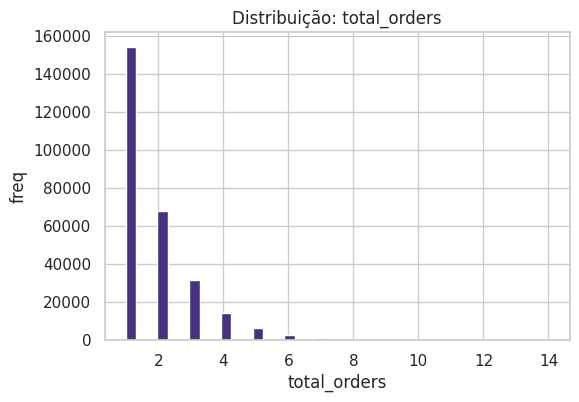

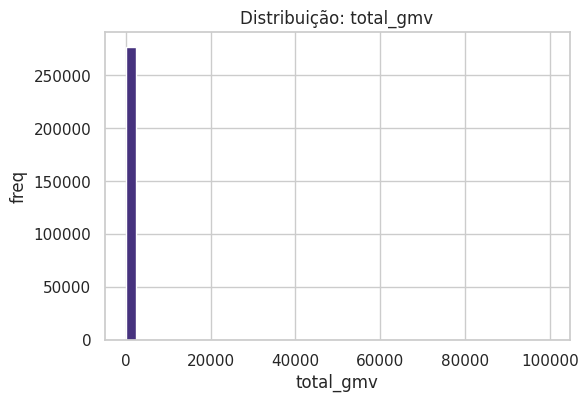

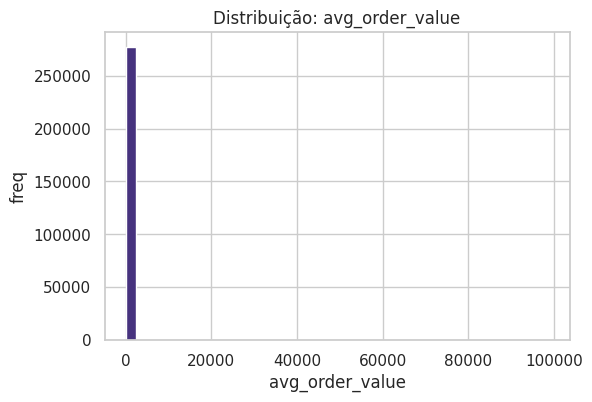

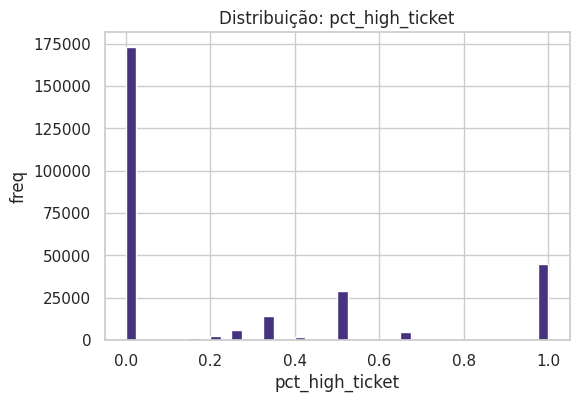

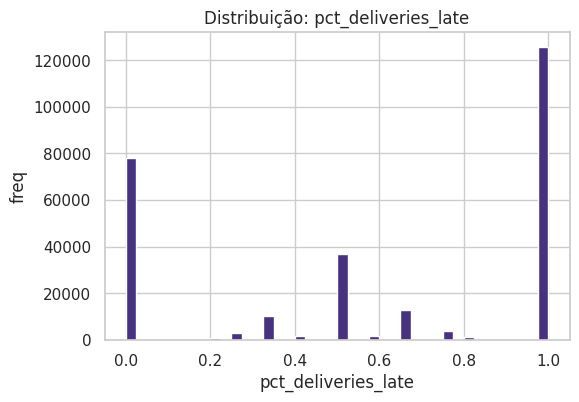

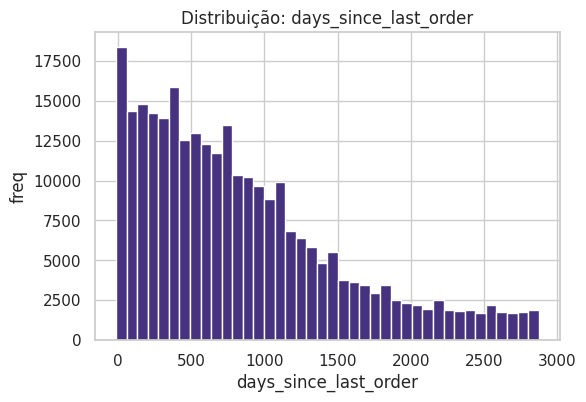

In [ ]:
# Distribuições rápidas (histogramas)
cols_hist = ["total_orders","total_gmv","avg_order_value","pct_high_ticket","pct_deliveries_late","days_since_last_order"]
for c in cols_hist:
    series = customers[c].dropna()
    plt.figure(figsize=(6,4))
    plt.hist(series, bins=40)
    plt.title(f"Distribuição: {c}")
    plt.xlabel(c); plt.ylabel("freq")
    plt.show()


In [ ]:
# =========================================================
# Coortes e atividade
# =========================================================
# Coorte mensal: quantos clientes entraram por mês
cohort_counts = customers.groupby("cohort_month")["customer_id"].nunique().reset_index(name="new_customers")
cohort_counts.head()

# Ativos 90d por coorte
cohort_active = (
    customers.groupby("cohort_month")["is_active_90d"]
    .mean().reset_index(name="active_90d_rate")
)
cohort_active.head()

# Mesclar e visualizar tendência
cohort_view = cohort_counts.merge(cohort_active, on="cohort_month", how="left").sort_values("cohort_month")
cohort_view.head(24)


,cohort_month,new_customers,active_90d_rate
0,2018-01,1391,0.00
1,2018-02,1116,0.01
2,2018-03,1211,0.01
3,2018-04,1261,0.01
4,2018-05,1335,0.01
5,2018-06,1310,0.02
6,2018-07,1314,0.01
7,2018-08,1331,0.01
8,2018-09,1406,0.01
9,2018-10,1517,0.02


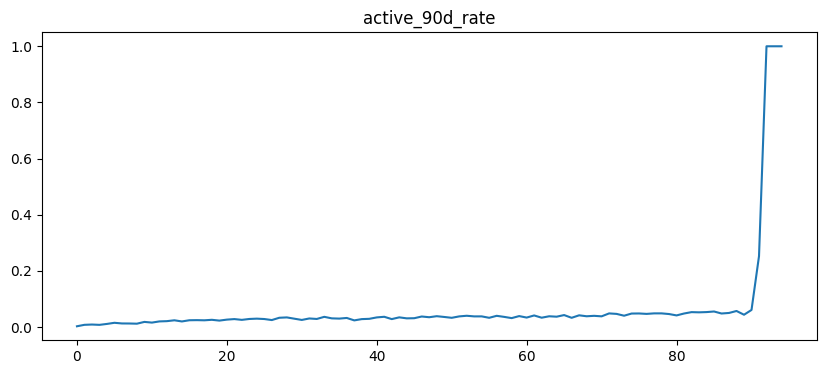

In [ ]:
# =============================
# Plot geral do GMV
# =============================
plt.style.use("default")

cohort_view["active_90d_rate"].plot(kind="line", figsize=(10,4), title="active_90d_rate")
plt.show()

In [ ]:
# Top regiões
reg = customers["most_frequent_region"].value_counts(dropna=False).rename_axis("region").reset_index(name="customers")
reg

,region,customers
0,Sudeste,162285
1,Sul,46035
2,Nordeste,40612
3,Centro-Oeste,16354
4,Norte,12681
5,Desconhecida,219


In [ ]:
# Método de pagamento dominante
pay = customers["most_used_payment"].value_counts(dropna=False).rename_axis("payment").reset_index(name="customers")
pay


,payment,customers
0,credit_card,178416
1,pix,65269
2,boleto,27623
3,paypal,6419
4,NaN,459


RFM é um método comum pra segmentar clientes com base no comportamento de compra, para isso dividimos os clientes em e bins pra cada categoria (Reência, Frequência e Financeiro)


In [ ]:
# =========================================================
# Segmentação simples por valor e recência (RFM-lite)
# =========================================================
# R: recency = days_since_last_order (quanto menor, melhor)
# F: frequency = total_orders
# M: monetary = total_gmv
# Bins em tercis para simplicidade
customers["R_bin"] = pd.qcut(customers["days_since_last_order"], 3, labels=[3,2,1])  # 3=recente, 1=antigo
customers["F_bin"] = pd.qcut(customers["total_orders"].rank(method="first"), 3, labels=[1,2,3])  # 3=frequente
customers["M_bin"] = pd.qcut(customers["total_gmv"].rank(method="first"), 3, labels=[1,2,3])     # 3=alto valor

customers["RFM_score"] = customers[["R_bin","F_bin","M_bin"]].astype(int).sum(axis=1)

# Faixas de segmento
def label_segment(row):
    if row["RFM_score"] >= 8:   return "Champions"
    if row["RFM_score"] >= 6:   return "Leais"
    if row["RFM_score"] >= 4:   return "Potenciais"
    return "Em risco"

customers["segment_rfm"] = customers.apply(label_segment, axis=1)

In [ ]:
customers[["customer_id","R_bin","F_bin","M_bin","RFM_score","segment_rfm"]].tail(10)

,customer_id,R_bin,F_bin,M_bin,RFM_score,segment_rfm
278176,99990,1,2,3,6,Leais
278177,99991,1,3,3,7,Leais
278178,99992,1,3,2,6,Leais
278179,99993,1,3,3,7,Leais
278180,99994,1,3,3,7,Leais
278181,99995,2,3,3,8,Champions
278182,99996,1,2,3,6,Leais
278183,99997,3,3,3,9,Champions
278184,99998,1,2,1,4,Potenciais
278185,99999,1,2,3,6,Leais


In [ ]:
# Método de pagamento dominante
pay = customers["segment_rfm"].value_counts(dropna=False).rename_axis("segment_rfm").reset_index(name="customers")
pay

,segment_rfm,customers
0,Leais,111394
1,Potenciais,92403
2,Champions,59347
3,Em risco,15042


In [ ]:
# =========================================================
# Indicadores operacionais
# =========================================================
# Atraso médio por região
op_region = (
    customers
    .groupby("most_frequent_region")[["avg_days_to_delivery","pct_deliveries_late"]]
    .mean()
    .sort_values("pct_deliveries_late", ascending=False)
)
op_region


,avg_days_to_delivery,pct_deliveries_late
most_frequent_region,,
Desconhecida,5.79,0.63
Norte,13.05,0.59
Sudeste,3.55,0.59
Nordeste,13.04,0.59
Centro-Oeste,8.38,0.59
Sul,6.04,0.59


In [ ]:
# =========================================================
# Tabela executiva (KPIs resumidos)
# =========================================================
kpis = pd.DataFrame({
    "n_customers":[customers.shape[0]],
    "active_90d_rate":[customers["is_active_90d"].mean()],
    "avg_total_orders":[customers["total_orders"].mean()],
    "avg_gmv":[customers["total_gmv"].mean()],
    "avg_aov":[customers["avg_order_value"].mean()],
    "avg_days_between_orders":[customers["avg_days_between_orders"].mean()],
    "late_delivery_rate":[customers["pct_deliveries_late"].mean()],
})
kpis.T


,0
n_customers,"278,186.00"
active_90d_rate,0.08
avg_total_orders,1.79
avg_gmv,479.25
avg_aov,268.77
avg_days_between_orders,420.57
late_delivery_rate,0.59


In [ ]:
customers.to_csv("customers.csv", index=False, encoding="utf-8")

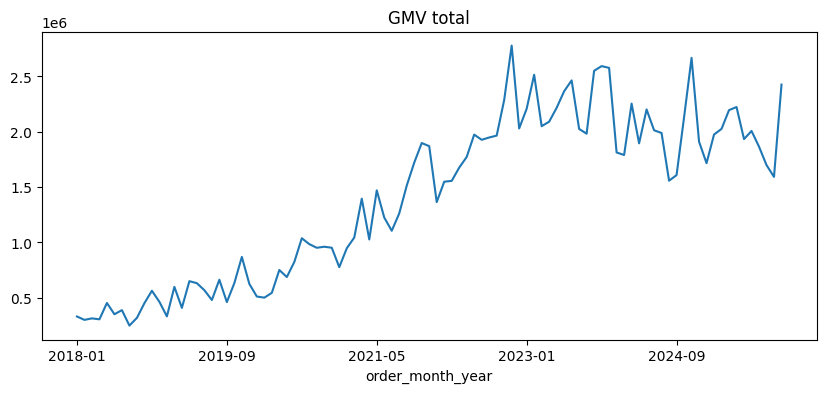

In [ ]:
# =============================
# Plot geral do GMV
# =============================
plt.style.use("default")

diagnostic["total_gmv"].plot(kind="line", figsize=(10,4), title="GMV total")
plt.show()

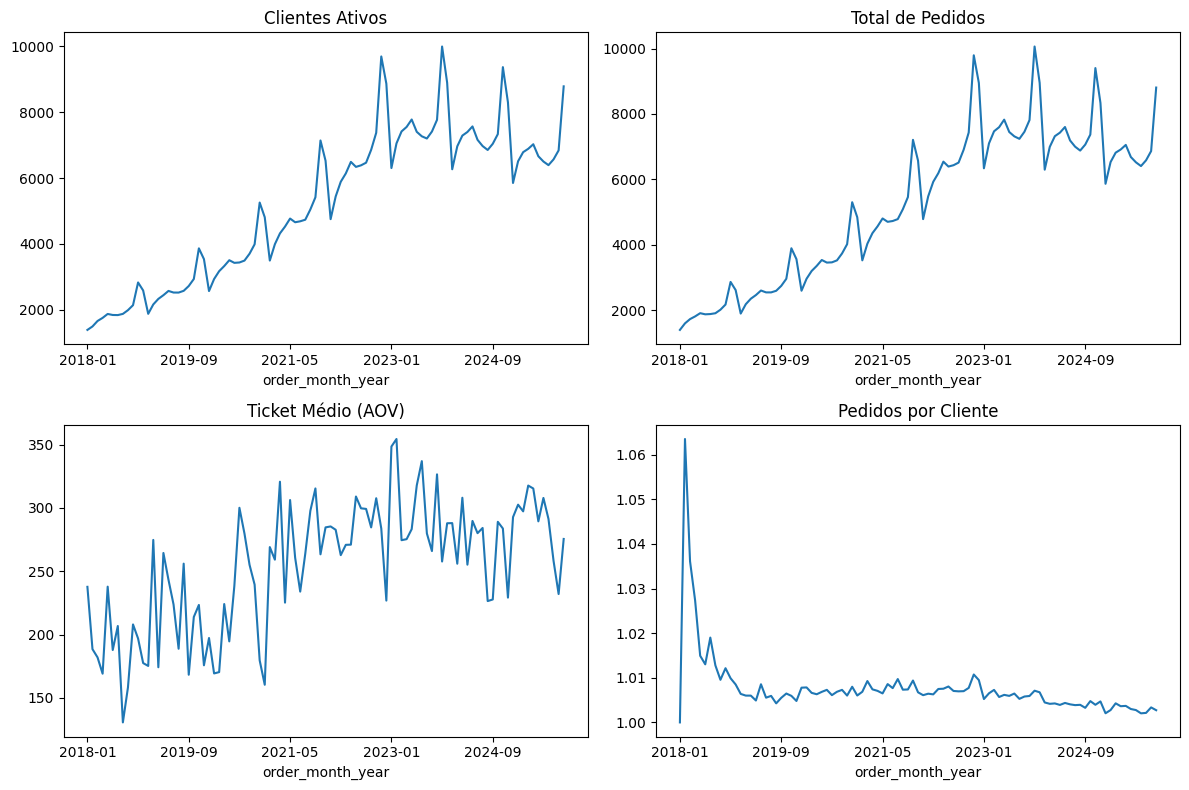

In [ ]:
# =============================
# 1. Drivers macro do GMV
# =============================

fig, axes = plt.subplots(2, 2, figsize=(12,8))

diagnostic["active_customers"].plot(ax=axes[0,0], title="Clientes Ativos")
diagnostic["total_orders"].plot(ax=axes[0,1], title="Total de Pedidos")
diagnostic["aov"].plot(ax=axes[1,0], title="Ticket Médio (AOV)")
diagnostic["orders_per_customer"].plot(ax=axes[1,1], title="Pedidos por Cliente")

plt.tight_layout()
plt.show()


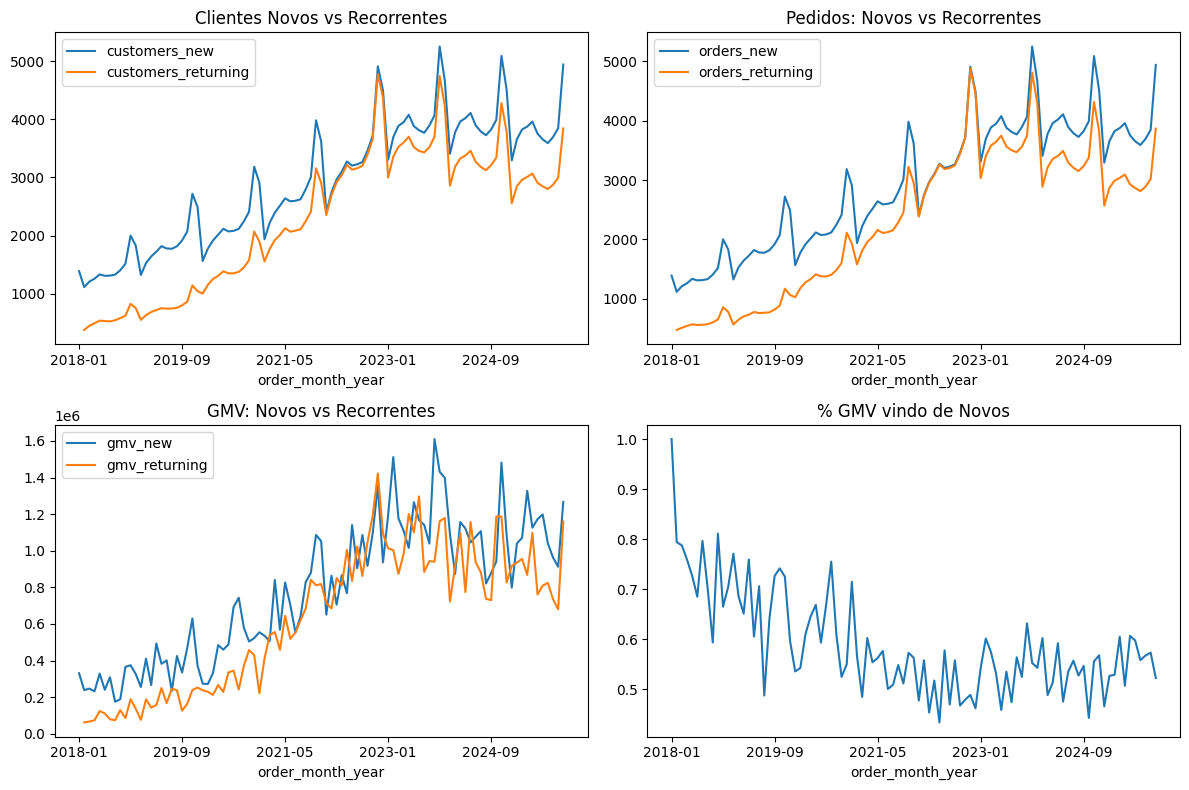

In [ ]:
# =============================
# Quebra Novos vs Recorrentes
# =============================

fig, axes = plt.subplots(2, 2, figsize=(12,8))

diagnostic[["customers_new","customers_returning"]].plot(ax=axes[0,0], title="Clientes Novos vs Recorrentes")
diagnostic[["orders_new","orders_returning"]].plot(ax=axes[0,1], title="Pedidos: Novos vs Recorrentes")
diagnostic[["gmv_new","gmv_returning"]].plot(ax=axes[1,0], title="GMV: Novos vs Recorrentes")
diagnostic["gmv_share_new"].plot(ax=axes[1,1], title="% GMV vindo de Novos")

plt.tight_layout()
plt.show()

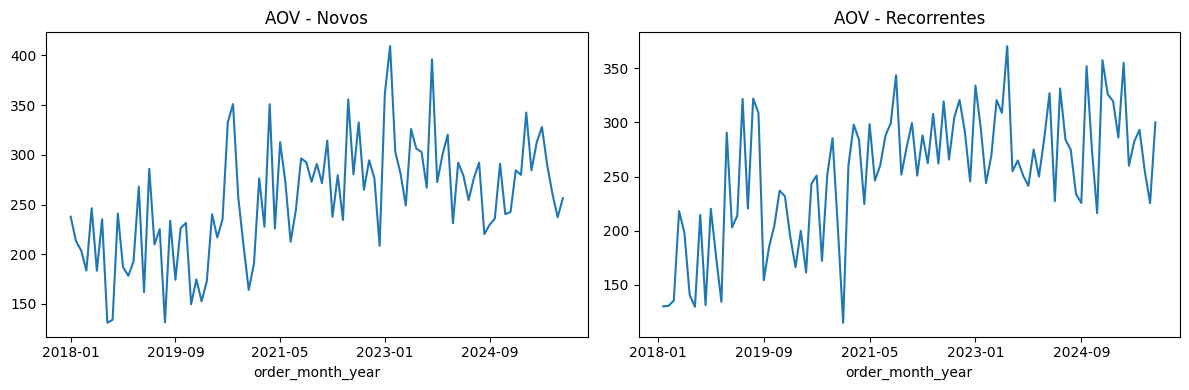

In [ ]:
# =============================
# Ticket médio por tipo de cliente
# =============================

fig, axes = plt.subplots(1, 2, figsize=(12,4))

diagnostic["aov_new"].plot(ax=axes[0], title="AOV - Novos")
diagnostic["aov_returning"].plot(ax=axes[1], title="AOV - Recorrentes")

plt.tight_layout()
plt.show()

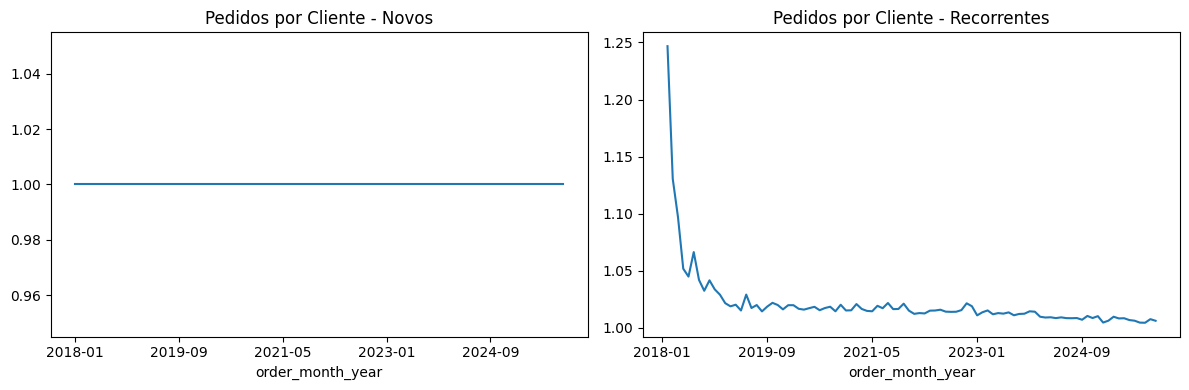

In [ ]:
# =============================
# Frequência por tipo de cliente
# =============================

fig, axes = plt.subplots(1, 2, figsize=(12,4))

diagnostic["orders_per_customer_new"].plot(ax=axes[0], title="Pedidos por Cliente - Novos")
diagnostic["orders_per_customer_returning"].plot(ax=axes[1], title="Pedidos por Cliente - Recorrentes")

plt.tight_layout()
plt.show()

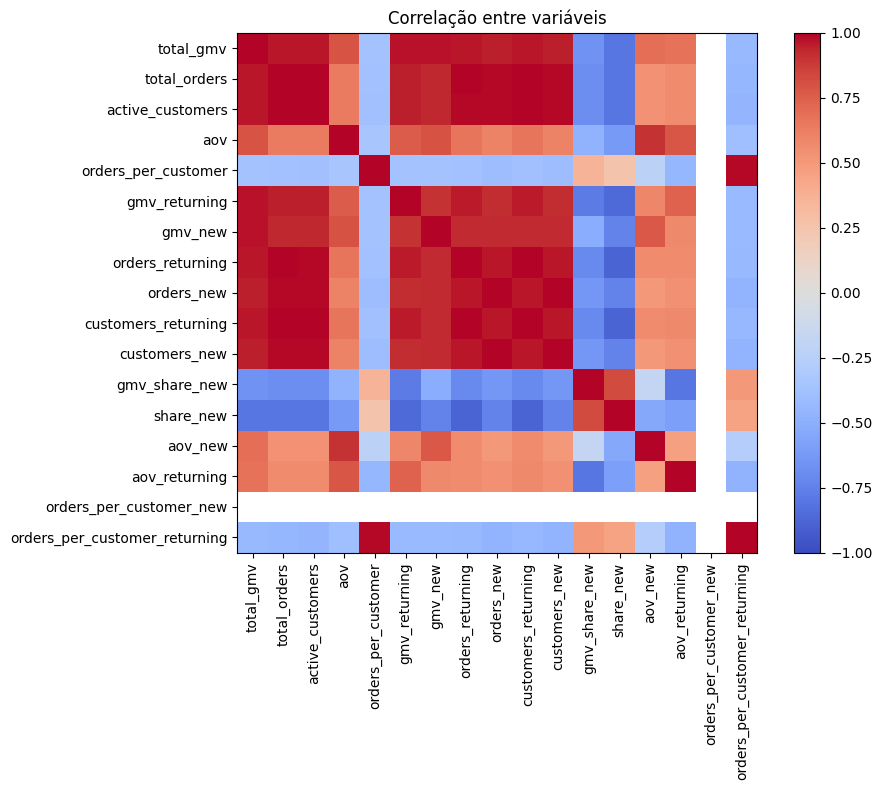

In [ ]:
# =============================
# Correlação para descobrir o driver
# =============================

corr = diagnostic.corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Correlação entre variáveis")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

In [ ]:
# Calcular CAGR
# Garantir datetime no índice
diagnostic.index = pd.to_datetime(diagnostic.index.astype(str))

# Cortar tudo antes de 2020
diagnostic = diagnostic[diagnostic.index >= "2020-01-01"]

# Separar dois períodos
before = diagnostic[diagnostic.index < "2023-01-01"]
after  = diagnostic[diagnostic.index >= "2023-01-01"]

def calc_cagr(df, col):
    # precisa de pelo menos 3 linhas para pular a primeira com NaN
    if len(df) < 3:
        return np.nan

    # pula o primeiro mês (que pode ter NaN de retornos)
    start = df[col].iloc[1]
    end   = df[col].iloc[-1]

    years = (df.index[-1] - df.index[1]).days / 365.25

    if start <= 0 or years <= 0:
        return np.nan

    return (end / start) ** (1 / years) - 1

metrics = diagnostic.columns
results = []

for col in metrics:
    cagr_before = calc_cagr(before, col)
    cagr_after  = calc_cagr(after, col)
    results.append([col, cagr_before, cagr_after])

cagr_df = pd.DataFrame(results, columns=["metric", "CAGR_before_2023", "CAGR_after_2023"])
cagr_df



,metric,CAGR_before_2023,CAGR_after_2023
0,total_gmv,0.64,-0.01
1,total_orders,0.48,0.08
2,active_customers,0.48,0.08
3,aov,0.11,-0.09
4,orders_per_customer,0.00,-0.00
5,gmv_returning,0.74,0.05
6,gmv_new,0.55,-0.06
7,orders_returning,0.60,0.05
8,orders_new,0.39,0.11
9,customers_returning,0.60,0.05


1) Crescimento geral (GMV, pedidos, clientes)

**Antes de 2023:**

* GMV: +64% ao ano

* Pedidos: +48%

* Clientes ativos: +48%
* AOV: + 11%

**Depois de 2023:**

* GMV: -1% ao ano (queda)

* Pedidos: +8%

* Clientes ativos: +8%
* **AOV: - 9% (queda)**

---
2) Ticket Médio — o principal problema

AOV geral:
* +11% → –9%

AOV por tipo:

* AOV_new: +12% → –16%

* AOV_returning: +9% → +1%


O ticket dos novos despencou brutalmente. O ticket dos recorrentes ficou quase flat (queda leve). **Esse é o maior driver isolado do GMV cair.**

---
3) Retenção (os recorrentes)

**Antes:**

* GMV_returning: +74%

* orders_returning: +60%

* customers_returning: +60%

**Depois:**

* GMV_returning: +5%

* orders_returning: +5%

* customers_returning: +5%

Antes, recorrentes eram a maior fonte de tração. Depois, eles só rondam o zero.
Esse é o segundo maior driver da estagnação.

---

4) Novos clientes (aquisição)

**Antes:**

* GMV_new: +55%

* orders_new: +39%

* customers_new: +39%

**Depois:**

* GMV_new: –6%

* orders_new: +11%

* customers_new: +11%

A aquisição ainda cresce (11% é decente). Mas o GMV dos novos cai por conta do ticket.

---

5) Mix de novos no GMV

* gmv_share_new: –6% → –5%

* share_new: –6% → +3%

O mix não é o problema principal. Ele fica estável, mas indica que temos menos recorrente (já identificado).

---

6) Frequência (orders per customer)

* 0% → 0%

A frequência ficou baixa e constante. Nem melhorou, nem piorou.

---

**🎯 Conclusão final por ordem de impacto no GMV pós-2023:**

* Ticket médio despencou (–9%), puxado principalmente por novos (–16%).

* Retenção deixou de ser motor (+74% → +5%).

* Aquisição desacelerou fortemente (+39% → +11%).

* Frequência estagnada não ajuda.

H1 – “Mix de novos deteriorou” (novos vindo com menos ticket / categorias baratas)

Outra avaliação: “Categorias de alto ticket perderam share”


In [ ]:
#Decompor GMV por categoria pré vs pós-2023.


# criar quartil do ticket (1 = mais baixo, 4 = mais alto)
orders["ticket_quartile"] = pd.qcut(
    orders["order_value"],
    4,
    labels=[1, 2, 3, 4]
).astype(int)

orders["order_year_month"] = orders["order_date"].dt.to_period("M")

high_share_by_month = (
    orders
    .groupby("order_year_month")
    .agg(
        pct_high_tickets=("ticket_quartile", lambda s: (s == 4).mean())
    )
)

# opcional: em %
high_share_by_month["pct_high_tickets"] = high_share_by_month["pct_high_tickets"] * 100


In [ ]:
high_share_by_month.tail(24)

,pct_high_tickets
order_year_month,
2023-12,26.61
2024-01,28.69
2024-02,28.40
2024-03,28.31
2024-04,27.90
2024-05,28.64
2024-06,28.23
2024-07,28.84
2024-08,28.44


<Axes: title={'center': '% de tickets no top 25% por mês'}, xlabel='order_year_month'>

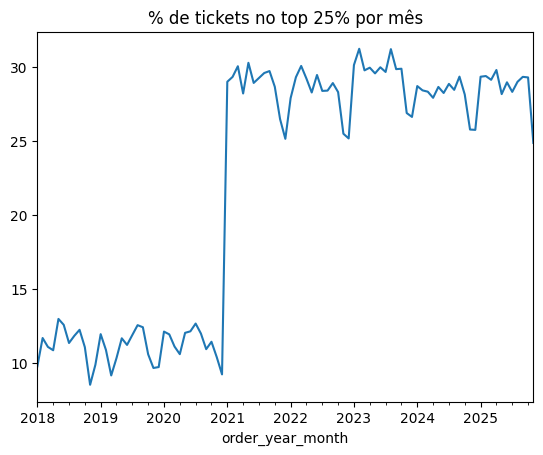

In [ ]:
high_share_by_month["pct_high_tickets"].plot(kind="line", title="% de tickets no top 25% por mês")


Outra avaliação: “Descontos aumentaram e comeram ticket/margem”

In [ ]:
orders["discount_pct"] = orders["discount_value"] / orders["total_order_value"]

discount_summary = (
    orders
    .assign(period=lambda df: np.where(df["order_date"] < "2023-01-01", "pre_2023", "post_2023"))
    .groupby("period")
    .agg(
        avg_discount_pct=("discount_pct", "mean"),
        median_discount_pct=("discount_pct", "median"),
        aov=("order_value", "mean")
    )
)

print(discount_summary)


           avg_discount_pct  median_discount_pct    aov
period                                                 
post_2023              0.10                 0.09 285.15
pre_2023               0.08                 0.06 249.76


## 5. MODELAGEM DO PROBLEMA

🎯 **Objetivo:**  Descobrir quais variáveis explicam a queda de AOV pós-2023 e qual o tamanho do efeito de cada uma.

Modelo: Regressão multivariada explicativa (GLM / OLS / Lasso/Ridge).

### Feature engineering

In [ ]:
# Criando cópia pra trabalhar
df = orders.copy()

In [ ]:
# evitar divisão por zero no desconto
df["discount_pct"] = df["discount_value"] / df["total_order_value"].replace(0, np.nan)

In [ ]:
# flag pós-2023
df["is_post2023"] = (df["order_date"] >= "2023-01-01").astype(int)

In [ ]:
# tirar orders com valor <= 0
df = df[df["order_value"] > 0].copy()

In [ ]:
df.columns

Index(['order_id', 'customer_id', 'order_date', 'order_status', 'order_value',
       'discount_value', 'sku_count', 'order_category', 'campaign_id',
       'payment_method', 'delivery_state', 'delivered_at',
       'estimated_delivery_date', 'sla_days', 'is_new_customer',
       'total_order_value', 'pct_discount', 'days_to_delivery',
       'delivery_delay_days', 'is_late_delivery', 'order_year', 'order_month',
       'order_month_year', 'order_week', 'holiday_tag', 'basket_size_flag',
       'high_ticket_flag', 'customer_lifetime_orders', 'customer_lifetime_gmv',
       'customer_avg_ticket_to_date', 'prev_order_date',
       'days_since_last_order_before_purchase', 'region',
       'is_new_customer_period', 'ticket_quartile', 'order_year_month',
       'discount_pct', 'is_post2023'],
      dtype='object')

In [ ]:
# Lista de features que serão utilizadas
num_features = [
    "sku_count",
    "discount_pct",
    "is_new_customer",
    "days_since_last_order_before_purchase",
    "customer_lifetime_orders",
    "customer_lifetime_gmv",
    "customer_avg_ticket_to_date",
    "is_late_delivery",
    "is_post2023",
]

cat_features = [
    "order_category",
    "region",
    "payment_method",
]


In [ ]:
# numéricas
X_num = df[num_features]

# categóricas → dummies numéricas
X_cat = pd.get_dummies(df[cat_features], drop_first=True)

# junta tudo
X = pd.concat([X_num, X_cat], axis=1)

In [ ]:
# troca inf por NaN
X = X.replace([np.inf, -np.inf], np.nan)

In [ ]:
# target
y = df["order_value"]

In [ ]:
# força tudo a ser numérico
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")

In [ ]:
# remove linhas com NaN em X ou y
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask]

In [ ]:
# adiciona constante
X = sm.add_constant(X)

### Rodar OLS (Regressão linear Múltipla Variada)

In [ ]:
# garante float64
X = X.astype(float)
y_model = y.astype(float)

In [ ]:
# Roda modelo

model = sm.OLS(y_model, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            order_value   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     6820.
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:04:55   Log-Likelihood:            -1.9421e+06
No. Observations:              219046   AIC:                         3.884e+06
Df Residuals:                  219025   BIC:                         3.885e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

VIF Valores de referência:

* VIF < 5 → ok
* VIF 5–10 → atenção
* VIF > 10 → multicolinearidade séria

In [ ]:
features_base = ['discount_pct', 'is_post2023', 'order_category_beleza', 'order_category_casa', 'order_category_eletro']

X_filtered = X[features_base]
# adiciona constante
X_filtered = sm.add_constant(X_filtered)

In [ ]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219046 entries, 3172 to 448176
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   const                  219046 non-null  float64
 1   discount_pct           219046 non-null  float64
 2   is_post2023            219046 non-null  float64
 3   order_category_beleza  219046 non-null  float64
 4   order_category_casa    219046 non-null  float64
 5   order_category_eletro  219046 non-null  float64
dtypes: float64(6)
memory usage: 11.7 MB


In [ ]:
# tira constante do VIF
X_vif = X_filtered

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(len(X_vif.columns))]

vif_data.sort_values("VIF", ascending=False)


,feature,VIF
0,const,5.05
3,order_category_beleza,1.31
4,order_category_casa,1.30
5,order_category_eletro,1.20
1,discount_pct,1.10
2,is_post2023,1.07


In [ ]:
# Roda modelo
model = sm.OLS(y_model, X_filtered).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            order_value   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     454.9
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:18:53   Log-Likelihood:            -1.9940e+06
No. Observations:              219046   AIC:                         3.988e+06
Df Residuals:                  219040   BIC:                         3.988e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   306.49

### Rodar modelo LightGBM

In [ ]:
# Treino = 2023 e 2024
train_mask = df["order_date"] < "2025-01-01"
# Teste = 2025 inteiro
test_mask  = df["order_date"] >= "2025-01-01"

X_train = X[train_mask].dropna()
y_train = y[train_mask].loc[X_train.index]

X_test = X[test_mask].dropna()
y_test = y[test_mask].loc[X_test.index]

/tmp/ipython-input-711627869.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[train_mask].dropna()
/tmp/ipython-input-711627869.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X[test_mask].dropna()


In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "verbose": -1
}

model = lgb.train(params, train_data, num_boost_round=200)

y_pred_2025 = model.predict(X_test)

print("R² (treinando 2023–2024, testando 2025):", r2_score(y_test, y_pred_2025))

R² (treinando 2023–2024, testando 2025): 0.8443307295131304


In [ ]:
feat_importance = (
    pd.Series(model.feature_importance(importance_type="gain"), index=X_train.columns)
    .sort_values(ascending=False)
)
feat_importance

,0
discount_pct,"4,839,780,343,918.00"
customer_avg_ticket_to_date,"1,555,672,136,172.00"
customer_lifetime_gmv,"1,081,045,703,303.00"
days_since_last_order_before_purchase,"358,140,264,199.00"
customer_lifetime_orders,"121,392,701,199.00"
order_category_eletro,"72,627,351,615.00"
sku_count,"45,812,156,145.00"
is_late_delivery,"43,628,811,092.00"
payment_method_credit_card,"41,648,247,981.00"
region_Sudeste,"37,824,001,763.00"


In [ ]:
feat_importance_norm = feat_importance / feat_importance.sum()
feat_importance_norm.sort_values(ascending=False)

,0
discount_pct,0.58
customer_avg_ticket_to_date,0.19
customer_lifetime_gmv,0.13
days_since_last_order_before_purchase,0.04
customer_lifetime_orders,0.01
order_category_eletro,0.01
sku_count,0.01
is_late_delivery,0.01
payment_method_credit_card,0.01
region_Sudeste,0.00


In [ ]:
X_sample = X.sample(frac=0.07, random_state=42)  # 7% é ótimo

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

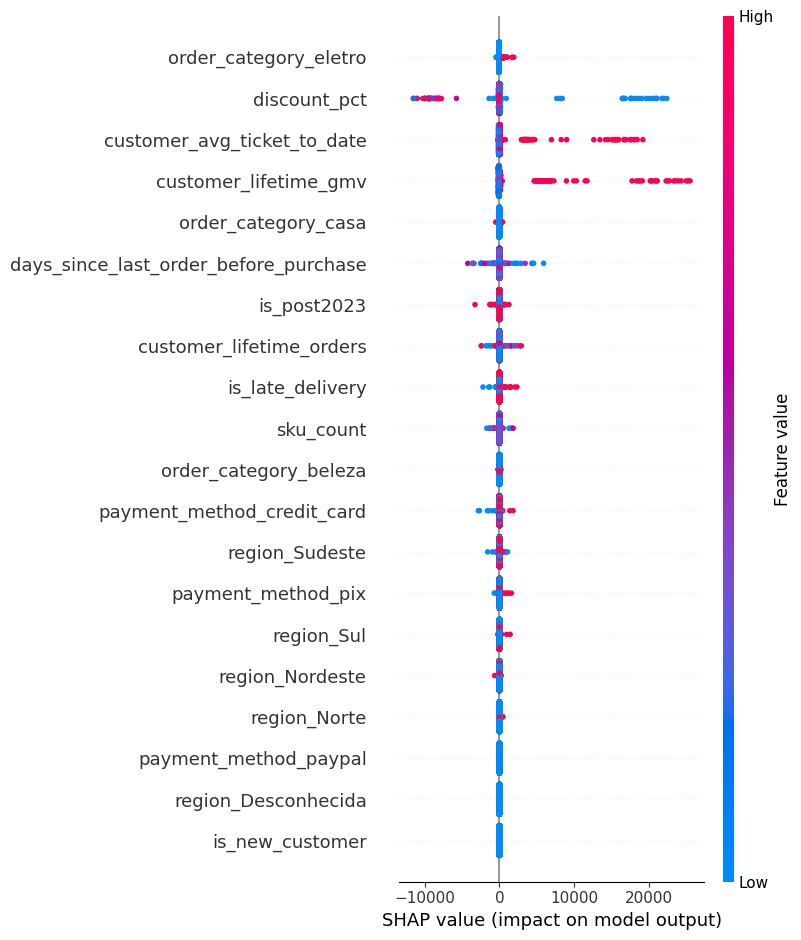

In [ ]:
shap.summary_plot(shap_values, X_sample)

A queda do ticket em 2025 = queda de margem = mudança de mix.

* aumentar exposição de produtos de alta margem
* empurrar combos high-margin
* reposicionar vitrine
* remover ruído de low-margin

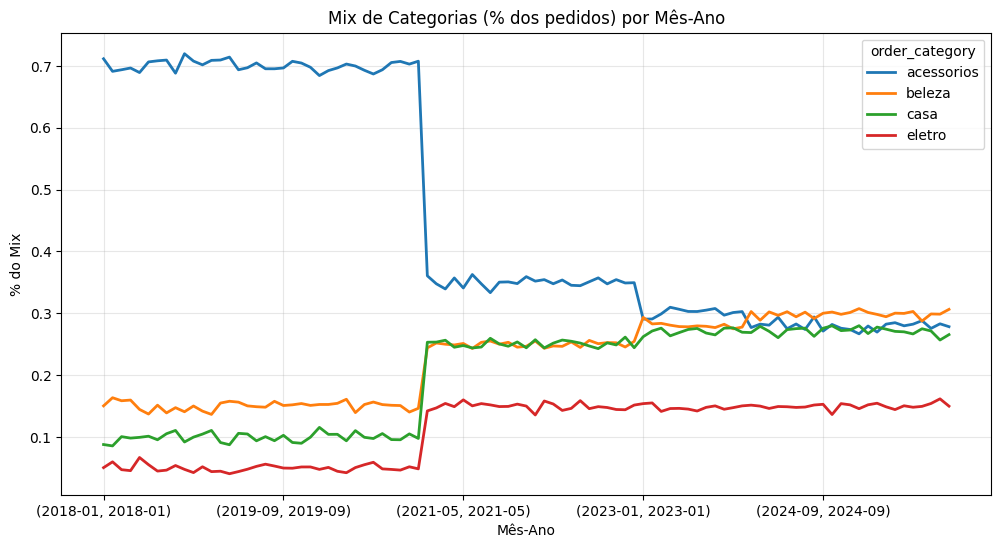

In [ ]:
mix = (
    orders.groupby(["order_year_month", "order_category"])
          .size()
          .groupby(level=0)
          .apply(lambda x: x / x.sum())
          .unstack()
)

mix.plot(figsize=(12,6), linewidth=2)
plt.title("Mix de Categorias (% dos pedidos) por Mês-Ano")
plt.ylabel("% do Mix")
plt.xlabel("Mês-Ano")
plt.grid(alpha=0.3)
plt.show()



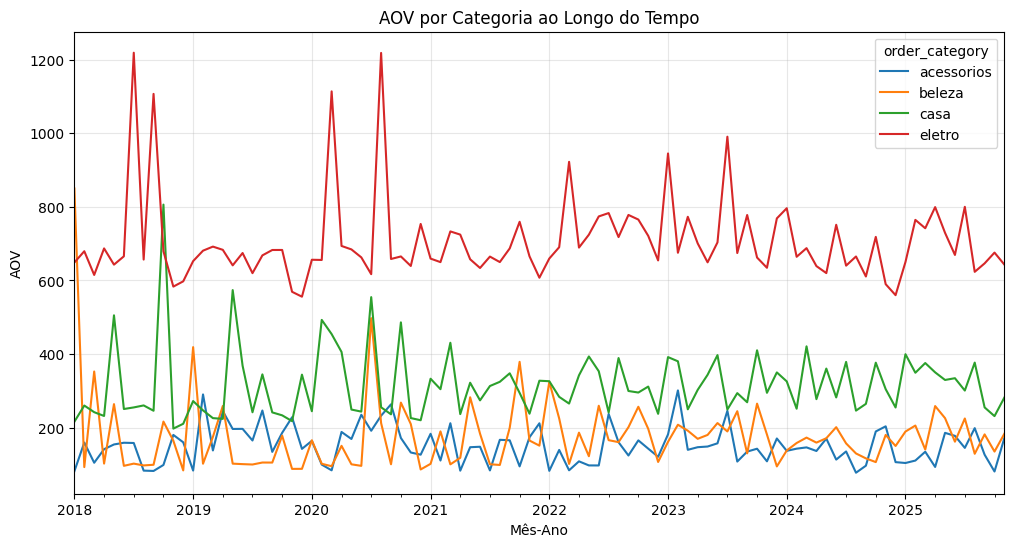

In [ ]:
 aov_cat = (
    orders.groupby(["order_year_month", "order_category"])["order_value"]
          .mean()
          .unstack()
)

aov_cat.plot(figsize=(12,6))
plt.title("AOV por Categoria ao Longo do Tempo")
plt.ylabel("AOV")
plt.xlabel("Mês-Ano")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
orders.groupby(["order_year_month", "order_category"])["order_value"].mean().unstack()


order_category,acessorios,beleza,casa,eletro
order_year_month,,,,
2018-01,82.10,849.65,216.51,648.91
2018-02,159.82,93.17,260.31,679.34
2018-03,104.97,352.74,242.30,614.96
2018-04,141.75,102.72,231.98,687.00
2018-05,154.64,264.10,505.32,642.95
...,...,...,...,...
2025-07,145.32,225.14,301.00,799.99
2025-08,198.94,129.33,376.93,623.41
2025-09,126.83,181.95,255.23,646.36


<Axes: xlabel='order_year_month'>

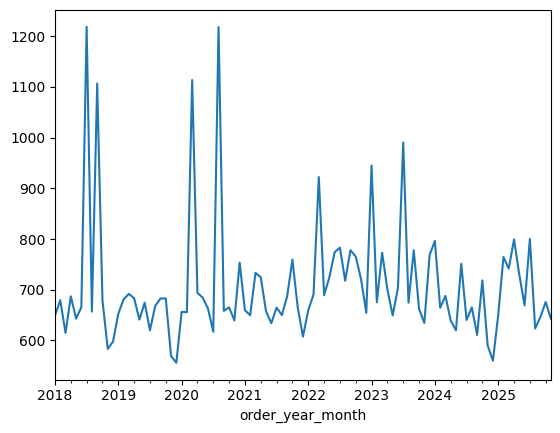

In [ ]:
orders[orders["order_category"]=="eletro"].groupby("order_year_month")["order_value"].mean().plot()


/tmp/ipython-input-600240821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eletro["ticket_bin"] = pd.qcut(eletro["order_value"], q=4, labels=False)


<Axes: xlabel='order_year_month'>

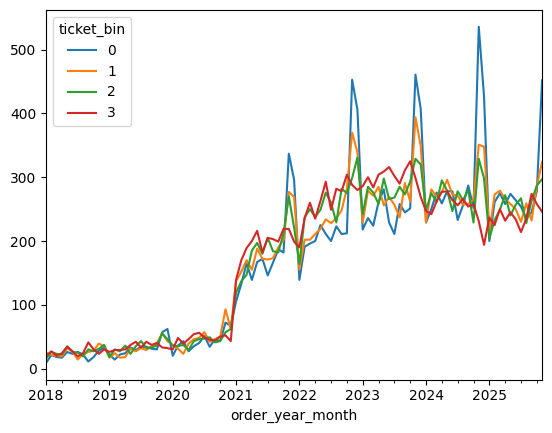

In [ ]:
eletro = orders[orders["order_category"]=="eletro"]
eletro["ticket_bin"] = pd.qcut(eletro["order_value"], q=4, labels=False)

eletro.groupby(["order_year_month", "ticket_bin"]).size().unstack().plot()


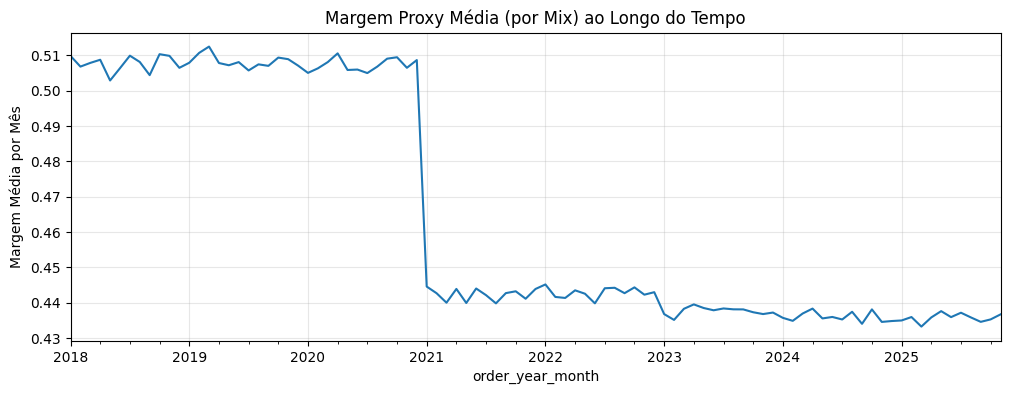

In [ ]:
(
    orders.groupby("order_year_month")["category_margin_pct"]
          .mean()
          .plot(figsize=(12,4))
)

plt.title("Margem Proxy Média (por Mix) ao Longo do Tempo")
plt.ylabel("Margem Média por Mês")
plt.grid(alpha=0.3)
plt.show()


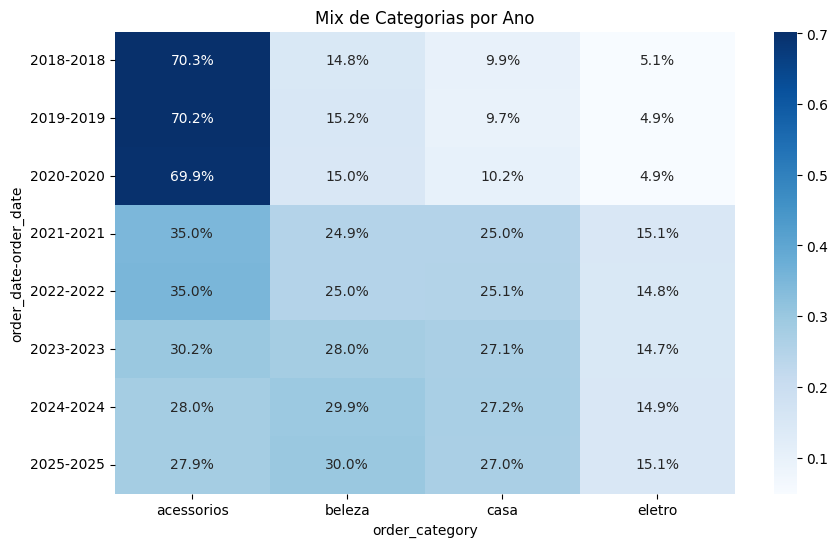

In [ ]:
import seaborn as sns

mix_year = (
    orders.groupby([orders["order_date"].dt.year, "order_category"])
          .size()
          .groupby(level=0)
          .apply(lambda s: s / s.sum())
          .unstack()
)

plt.figure(figsize=(10,6))
sns.heatmap(mix_year, annot=True, cmap="Blues", fmt=".1%")
plt.title("Mix de Categorias por Ano")
plt.show()


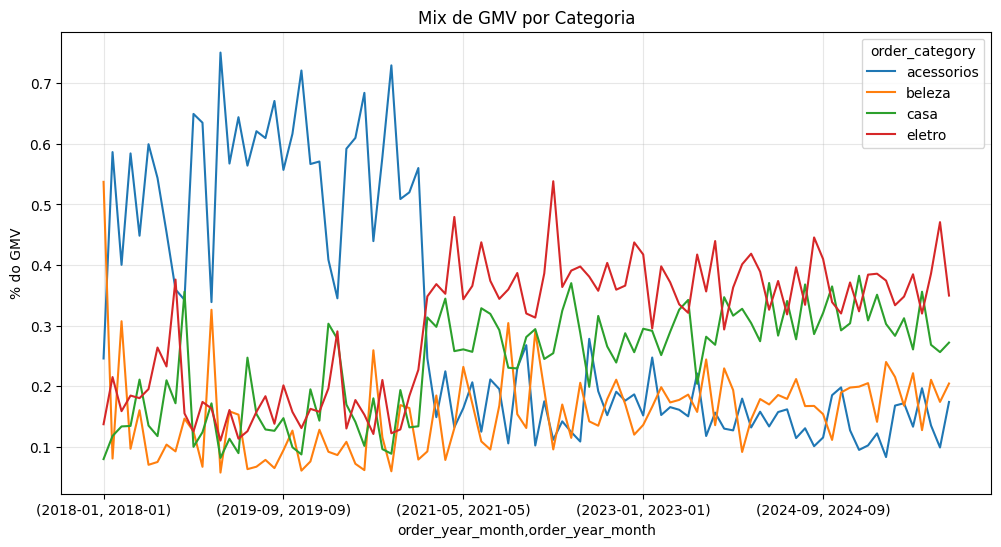

In [ ]:
mix_gmv = (
    orders.groupby(["order_year_month", "order_category"])["order_value"]
          .sum()
          .groupby(level=0)
          .apply(lambda x: x / x.sum())
          .unstack()
)

mix_gmv.plot(figsize=(12,6))
plt.title("Mix de GMV por Categoria")
plt.ylabel("% do GMV")
plt.grid(alpha=0.3)
plt.show()


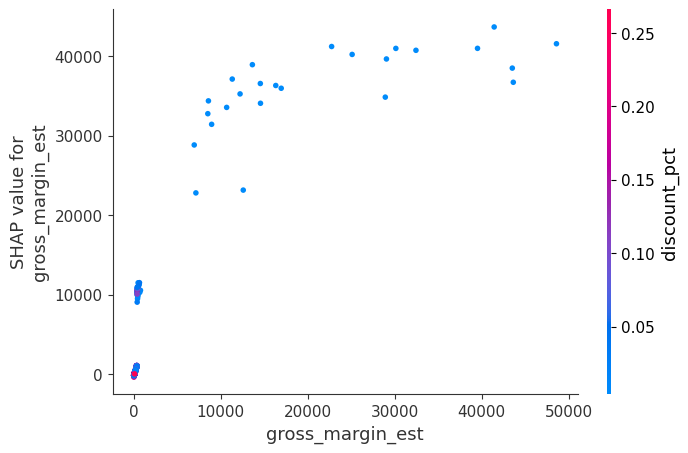

In [ ]:
shap.dependence_plot("gross_margin_est", shap_values, X_sample)


In [ ]:
shap.dependence_plot("discount_pct", shap_values, X)
shap.dependence_plot("sku_count", shap_values, X)
shap.dependence_plot("customer_lifetime_gmv", shap_values, X)